<h1 style="text-align: center;">A Matter of Mind: Pepito’s Cognitive Challenge and Dr. Cajal’s Skepticism</h1>

### Main Question
**Is Cognitive Fatigue Quantifiable in Wikispeedia, and What Role Does It Play in Gameplay?**

### Research Questions
Recent studies show that our attention spans are shrinking, and our brains can become fatigued within minutes of focused activity [(1)](https://doi.org/10.1111/psyp.12339). This project aims to investigate user engagement with Wikispeedia **game from a neuroscientific angle**, focusing on how article complexity impacts cognitive load and behaviour. Key questions include: 
- How does the complexity of articles affect user engagement? 
- Does the structure and layout (e.g., headings, multimedia) influence time spent, back-clicks, or path abandonment? 
- Is cognitive fatigue a factor in users abandoning navigation paths?

### Notebook Structure
In the following notebook, the main results from the data preprocessing, exploratory data analysis, and subsequent analyses will be reported. The goal is to **keep the explanations concise** and focus only on the most relevant code.

As a result, many times we will upload pre-processed data frames or datasets directly. Naturally, for each section that uses these pre-processed datasets, we will **link to the corresponding Jupyter notebook** with the relevant data. The entire set of Jupyter notebooks can be found [here](src/notebooks).



***

# Preprocess data

The first step of the pipeline involved preprocessing the raw data. Here, we uploaded the already preprocessed data, but the specific steps followed can be found in the [0_create_df.ipynb](src/notebooks/0_create_df.ipynb) notebook.

From now on, we will use the following terminology:
- **Path**: A set of articles that leads from a source to a target article. A path can be both finished or unfinished, meaning that the target articles has not been reached.
- **Article**: A single webpage.

For clarity, we report the steps followed in preprocessing for each piece of data:

<span style="font-size:28px">1. Article Names</span>

- Decoded article names.
- Added a numerical order encoding.

<span style="font-size:28px">2. Article Category</span>

- Decoded article names.
- Split the hierarchical categories into three different columns for each article.
- Removed duplicated articles (decision was to maintain only the first appearance).
- Manually added categories for 6 missing articles.

<span style="font-size:28px">3. Article Links in Network</span>

- Added columns with decoded article names.

<span style="font-size:28px">4. Paths</span>

- Finished and unfinished paths were merged into a single dataframe, paying attention to creating a column indicating whether the path is finished or not.
- For each path, **new metrics** were calculated (e.g., frequency of backlinks), which will be defined later.
- Paths were transformed into a list of articles (for better encoding) and encoded using numerical values.
- Backclicks were corrected. For instance, instead of having "<", the correct article was substituted.
- Incorrect paths (i.e. **Outliers**) were removed. These included:
    - Paths consisting of only one node that are unfinished due to "timeout".
    - Unfinished paths where the target article is not present in the original article dataframe.
    - Paths where the initial and final articles are the same.
    - Paths with a duration of 0 or greater than 5000 seconds.

<span style="font-size:28px">5. BFS Matrix</span>

- The BFS matrix was transformed into a dataframe to better work with it.

Lastly a **search of NaN values** was perfomed, highlighting only 3 paths that have NaN as hashed IP address. As this the IP address was not used for further analysis, we decided to mantain these paths.


In [1]:
import ast
from collections import Counter
import os

import networkx as nx

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split


from scipy.stats import ks_2samp, mannwhitneyu, pointbiserialr, ttest_ind

# Our libraries
from src.utils.position import get_parents_distribution, get_position_distribution


print(os.getcwd())

/Users/return0/Study/Learning/EPFL/ADA-group/ada-2024-project-theadacuates


In [2]:
df_path = pd.read_csv("data/output/processed_data/paths_processed.csv", low_memory=False)
df_article = pd.read_csv("data/output/processed_data/articles_processed.csv")
df_raw = pd.read_csv('data/output/processed_data/unfiltered_paths_processed.csv', low_memory=False)
df_categories = pd.read_csv('data/output/processed_data/categories_processed.csv')

# Exploratory Data Analysis

Before presenting our analysis and the narrative that will describe it, we will provide a brief summary of the data exploration (EDA).

For more information please check the following [notebook](src/notebooks/0_create_df.ipynb).

## 1. Comparison of raw data with processed data

Here we can observe how many paths we have removed after preprocessing.

In [3]:
raw_row_count = df_raw.shape[0]
processed_row_count = df_path.shape[0]
removed_paths = raw_row_count - processed_row_count

print(f"Total rows in raw data: {raw_row_count}")
print(f"Total rows in processed data: {processed_row_count}")
print(f"Paths removed during preprocessing: {removed_paths}")


Total rows in raw data: 76193
Total rows in processed data: 74114
Paths removed during preprocessing: 2079


Here we can observe the final number of finished and unifinished paths before and after the preprocessing.

In [4]:
# Count finished vs. unfinished in raw data
raw_finished_counts = df_raw['finished'].value_counts()
print("Raw Data - Finished/Unfinished Counts:\n", raw_finished_counts)

# Count finished vs. unfinished in processed data
processed_finished_counts = df_path['finished'].value_counts()
print("Processed Data - Finished/Unfinished Counts:\n", processed_finished_counts)


Raw Data - Finished/Unfinished Counts:
 finished
True     51318
False    24875
Name: count, dtype: int64
Processed Data - Finished/Unfinished Counts:
 finished
True     51280
False    22834
Name: count, dtype: int64


Here we can observe the percentage of finished paths before and after the processing.

In [5]:
# Calculate percentage of finished paths in each dataset
raw_finished_ratio = raw_finished_counts[True] / raw_row_count
processed_finished_ratio = processed_finished_counts[True] / processed_row_count

print(f"Percentage of finished paths in before processing data: {raw_finished_ratio:.2%}")
print(f"Percentage of finished paths in processed data: {processed_finished_ratio:.2%}")

Percentage of finished paths in before processing data: 67.35%
Percentage of finished paths in processed data: 69.19%


### Observation:

During data preprocessing, we removed 2,079 paths, bringing the total down from 76,193 to 74,114. This process slightly increased the proportion of finished paths, going from 67.35% in the raw data to 69.19% in the processed data. More unfinished paths were filtered out from the data.

After analyzing the distribution of finished and unfinished paths, we conclude that rebalancing the data between these two categories is unnecessary. The current dataset's proportion of finished to unfinished paths reflects real user behavior and naturally occurring navigation patterns. Adjusting these proportions would risk distorting the genuine trends and insights we aim to capture.

## 2. Data Enrichment and Description of the features
In addition to the basic features provided in the dataset, we decided to **enrich** it with new features and metrics. Below, we provide descriptions of all the variables used for the analysis, along with their corresponding explanations.


| Field                         | Description                                                                                                  |
|-------------------------------|--------------------------------------------------------------------------------------------------------------|
| **hashed_ip**                  | An anonymized identifier for the user, generated from the IP address. Helps track unique users across sessions without compromising privacy. |
| **timestamp**                  | The Unix timestamp representing the starting time of the session. Can be converted to human-readable date and time for time-based analysis. |
| **duration**                   | The time spent on the path in seconds. Indicates how long users took to complete or attempt the path, reflecting difficulty or engagement level. |
| **path**                       | A semicolon-separated string representing the sequence of pages the user visited. Provides insights into user navigation. |
| **rating**                     | A numeric rating given to the session, possibly indicating satisfaction or perceived value of the session.      |
| **path_list**                  | The path represented as a list of page names, making it easier to analyze specific steps within each path programmatically. |
| **source_link**                | The starting page of the path, indicating where the user initiated navigation. Useful for understanding common starting points. |
| **target_link**                | The ending page of the path, showing the final destination in the user’s navigation. Reveals common endpoints.  |
| **finished**                   | A boolean indicating whether the path was completed (`True`) or not (`False`). Differentiates between successful and abandoned sessions. |
| **type_unfinished**            | If the path is not finished, this field may indicate the reason for abandonment (e.g., `timeout` or `restart`). Analyzes reasons for incomplete sessions. |
| **n_click**                    | The total number of clicks or pages visited in the path. Helps determine the length and complexity of each session. |
| **n_back**                     | The number of times the user clicked back to a previous page in the session. May indicate difficulty or indecision. |
| **date**                       | A human-readable date derived from the timestamp, enabling analysis based on specific dates or timeframes.       |
| **click_rate**                 | The rate of clicks per second, calculated as `n_click / duration`. Higher rates may suggest faster, less engaged navigation. |
| **normalized_duration**        | The average time spent per click, calculated as `duration / n_click`. Indicates the depth of engagement with each page visited. |
| **freq_back**                  | The frequency of back clicks relative to the total number of clicks, calculated as `n_back / n_click`. A high frequency may indicate uncertainty or difficulty. |
| **path_list_id**               | A list of unique identifiers for each page in `path_list`, represented as numeric IDs. Efficient for programmatic references. |
| **resolved_path_list_id**      | Similar to `path_list_id`, containing page IDs after necessary transformations. Ensures consistent analysis when page names may vary. |
| **resolved_path_list_name**    | The final list of page names in the path after transformations, ensuring consistency in names across the dataset. This is the definitive path used for analysis. |


## 3. Exploration of the most visited pages

In this analysis, we aim to understand which pages receive the most visits in our dataset. We’ll identify the top **20 most-visited pages**, calculate what proportion of total visits they account for, and then visualize this distribution with a donut chart. This will give us a clear picture of whether a few popular pages dominate user activity or if visits are spread out across many pages.

In [6]:
# Convert path_list strings to actual lists if necessary
df_path['resolved_path_list_name'] = df_path['resolved_path_list_name'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the list of pages and count occurrences of each page
all_pages = [page for path in df_path['resolved_path_list_name'] for page in path]
page_counts = Counter(all_pages)
top_20_pages = page_counts.most_common(20)

In [7]:
# Flatten the list of pages and count occurrences of each page
all_pages = [page for path in df_path['resolved_path_list_name'] for page in path]
page_counts = Counter(all_pages)

# Calculate total visits across all pages
total_visits = sum(page_counts.values())

# Calculate the visits for the top 20 pages
top_20_visits = sum(count for page, count in top_20_pages)

# Calculate the proportion of visits accounted for by the top 20 pages
top_20_proportion = top_20_visits / total_visits

print(f"\nThe Top 20 pages account for {top_20_proportion:.2%} of total visits in the game.")



The Top 20 pages account for 15.47% of total visits in the game.


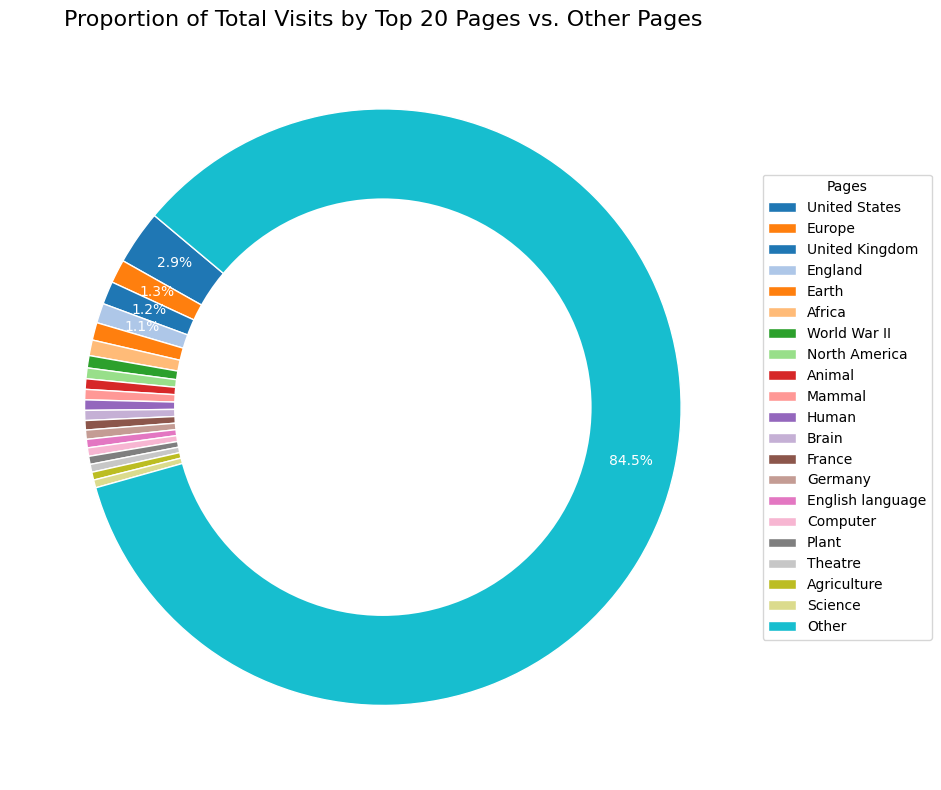

In [8]:
# Extract data for the top 20 pages
top_20_labels = [page for page, count in top_20_pages]
top_20_counts = [count for page, count in top_20_pages]

# Calculate the "Other" category for pages not in the top 20
other_count = total_visits - top_20_visits

# Add "Other" to the labels and counts
top_20_labels.append('Other')
top_20_counts.append(other_count)

# Define colors for the largest segments manually, then add a distinct palette for the remaining smaller segments
large_colors = ['#1f77b4', '#ff7f0e']  # e.g., blue and orange for the largest slices
remaining_colors = sns.color_palette('tab20', len(top_20_labels) - len(large_colors))
colors = large_colors + remaining_colors

# Plot a donut chart
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    top_20_counts,
    labels=[''] * len(top_20_labels),  # Remove text labels from slices
    autopct=lambda pct: f'{pct:.1f}%' if pct > 1 else '',  # Only show % for slices >1%
    startangle=140,
    colors=colors,
    pctdistance=0.85,  # Increase distance of percentages from the center
    wedgeprops={'edgecolor': 'w'}
)

# Draw a circle at the center to make it a donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Adjust font size and color of the percentage labels for visibility
for i, autotext in enumerate(autotexts):
    autotext.set_fontsize(10)
    autotext.set_color('white')
    # Add label name on the largest segment
    if top_20_labels[i] == 'Other':  # Assuming "Other" is the largest segment
        texts[i].set_text("Other")   # Add "Other" label on the largest slice
        texts[i].set_fontsize(12)
        texts[i].set_color('white')

# Add a legend with page names and counts for clarity
handles, _ = wedges, top_20_labels
plt.legend(handles, top_20_labels, title="Pages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Add title
plt.title('Proportion of Total Visits by Top 20 Pages vs. Other Pages', fontsize=16)
plt.tight_layout()
plt.show()


## 4. Exploring Categories

In this analysis, we're examining the distribution of article categories within our dataset.


In [9]:
# Load categories data 
df_categories = df_categories[['article_name', 'article_category_1']]
df_categories = df_categories.rename(columns={'article_category_1': 'primary_category'})

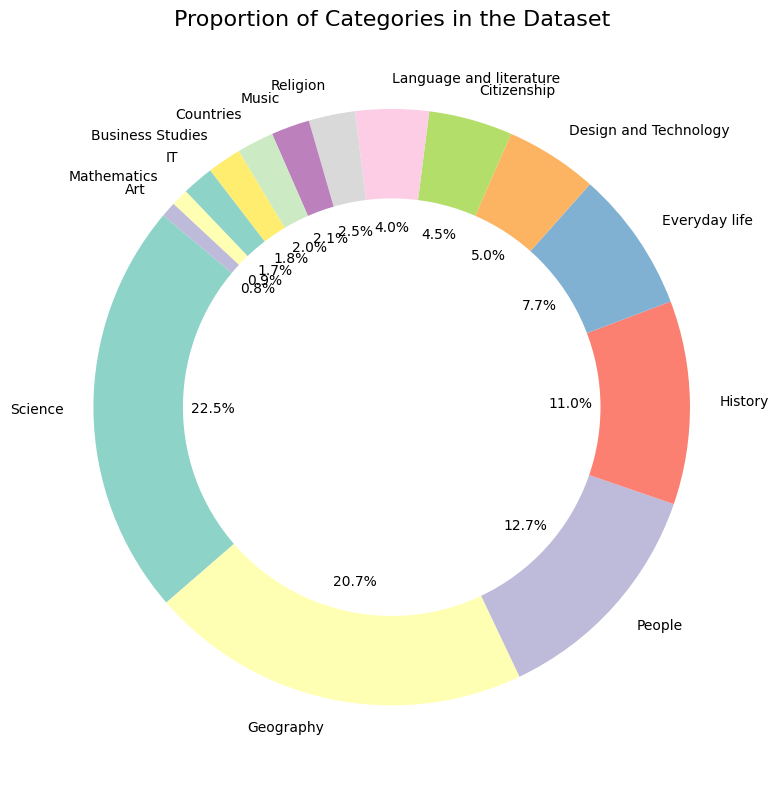

In [10]:
# Count the occurrences of each category before merging
category_counts = df_categories['primary_category'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 8))
colors = sns.color_palette('Set3', len(category_counts))  # Choose a color palette
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)

# Draw a circle at the center to make it a donut chart (optional)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Add title and adjust layout
plt.title('Proportion of Categories in the Dataset', fontsize=16)
plt.tight_layout()
plt.show()

Now, we aim to understand navigation patterns by examining how frequently players transition between different article categories. **By identifying the starting and ending categories of each path**.

In [11]:
# Remove duplicates to ensure each article has a unique category
df_categories = df_categories.drop_duplicates(subset=['article_name'])

# Merge to add start category based on `source_link`
df_path = df_path.merge(
    df_categories,
    left_on='source_link',
    right_on='article_name',
    how='left'
).rename(columns={'primary_category': 'start_category'})

# Merge to add end category based on `target_link`
df_path = df_path.merge(
    df_categories,
    left_on='target_link',
    right_on='article_name',
    how='left'
).rename(columns={'primary_category': 'end_category'})

# Drop redundant columns from merging
df_path = df_path.drop(columns=['article_name_x', 'article_name_y'])

# Count paths that start in one category and end in another
category_path_counts = df_path.groupby(['start_category', 'end_category']).size().unstack(fill_value=0)



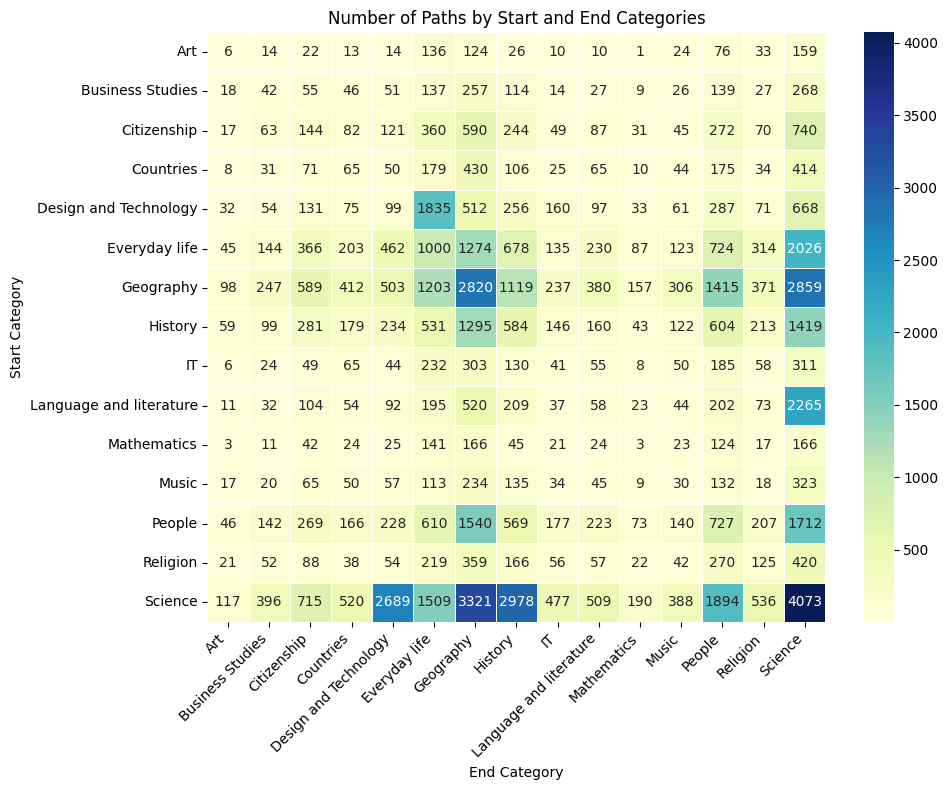

In [12]:
# Plot a heatmap of the category path counts
plt.figure(figsize=(10, 8))
sns.heatmap(category_path_counts, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title("Number of Paths by Start and End Categories")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Naturally, the results are as expected, as the combination of source and target categories with higher counts (e.g. from Science to Geography) also corresponds to those with higher frequency in the dataset. Since the game randomly selects the start and end articles, this outcome makes perfect sense after seeing the previously shown article category distribution.

## 5. General Conectivity Analysis 

For more details see [this notebook](src/notebooks/5_graph_analysis.ipynb).

This section's purpose is to give us some insight into the structure of the Wikispeedia network, node accessibility and graph navigability.

In [13]:
# reading a list of all the links between articles, original data is from raw file links.tsv
df_links_s = pd.read_csv('data/output/processed_data/links_simple_processed.csv')
# using networkx to create graph
G = nx.DiGraph()
G.add_edges_from(zip(df_links_s['link_source'], df_links_s['link_target']))

In [14]:
print("Wikispeedia's article network has a total of ", len(G.nodes), " nodes and ", len(G.edges), " edges")
print("Wikispeedia's article network has a density of ", nx.density(G)) 

Wikispeedia's article network has a total of  4592  nodes and  119882  edges
Wikispeedia's article network has a density of  0.005686496910710776


Wikispeedia's article network has a total of  4592  nodes and  119882  edges.

**Graph density** measures how many connections there are relative to the maximum number of possible connections. A density close to 1 means our graph is highly interconnected. Wikispeedia's network density is 0.0057, indicating a **sparseley connected** graph.

In [15]:
# Load the BFS matrix from CSV, original data from raw file shortest-path-distance-matrix.txt
bfs_matrix = pd.read_csv('data/output/processed_data/bfs_matrix.csv', index_col=0) 
print("Is the Wikispeedia network strongly connected?:", nx.is_strongly_connected(G))
print("Number of strongly connected components:", len(list(nx.strongly_connected_components(G))))
print("The longest optimal path in the Wikispeedia network is ", bfs_matrix.max().max())
print("Do we have isolated nodes? ", len(list(nx.isolates(G))) != 0)



Is the Wikispeedia network strongly connected?: False
Number of strongly connected components: 519
The longest optimal path in the Wikispeedia network is  9.0
Do we have isolated nodes?  False


The Wikispeedia network is *not strongly connected* meaning that there are some articles that cannot be reached by certain other articles by following the links (as visible also in the given BFS matrix).
In a not strongly connected graph, usually there are multiple *strongly connected components (SSC*). These components are subgraphs within our network where any node can reach any other node in the same component, but nodes in one SCC may not be able to reach nodes in another SCC. Wikispeedia has 519 strongly connected components.

Even in such a sparce network, we see that there are no isolated nodes and that the maximum shortest path (diameter of the network) is 9. This is relatively short, and from this we can infer that the network has "Hubs" which are highly connected nodes that may link "distant" parts of the network. 

Below, you will see the **top 10 articles ranked by various centrality measures**.

- **In-Degree Centrality**: This ranks articles based on the number of incoming links.

- **Out-Degree Centrality**: This ranks articles by the number of outgoing links they have.

- **Degree Centrality**: This is a combined measure that sums in-degree and out-degree, giving a general sense of an article's overall connectivity within the network. High degree centrality means that an article is both widely linked to and links out to many other articles, making it a potential *Hub*.

- **Closeness Centrality**: This measures how close an article is to all other articles in the graph. It is based on the *average shortest path distance* from a given article to all other articles that can be reached. A node with high closeness centrality reaches other nodes more quickly, which can indicate a high degree of accessibility within the graph (*a Hub!*).


In all our graphs, you can see the article "United States" is at the top for all these metrics, making it our biggest hub in the network. We can also see that articles that are lists (e.g. *List of Countries*) form a big portion of the top "Out degree centrality", which is expected.


Below we load the graph metrics dataframe from the Wikispeedia Network.

In [16]:
# Loading wikispedia graph metrics
df_metrics = pd.read_csv('data/output/graph_data/all_connections_graph_metrics.csv')

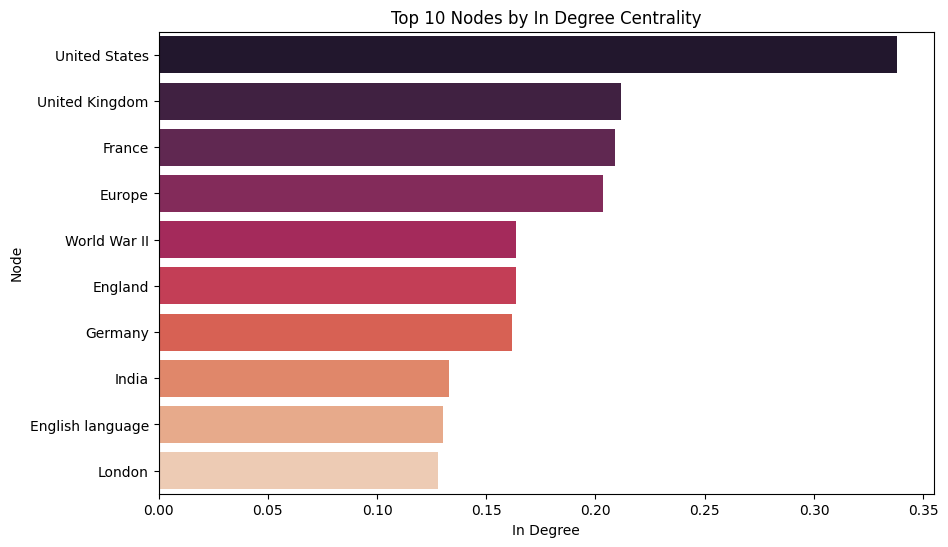

In [17]:
top_in_degree = df_metrics.sort_values(by="in_degree_centrality", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="in_degree_centrality", 
    y="node", 
    data=top_in_degree,
    hue="node",
    palette="rocket"
)
plt.xlabel("In Degree")
plt.ylabel("Node")
plt.title("Top 10 Nodes by In Degree Centrality")
plt.show()

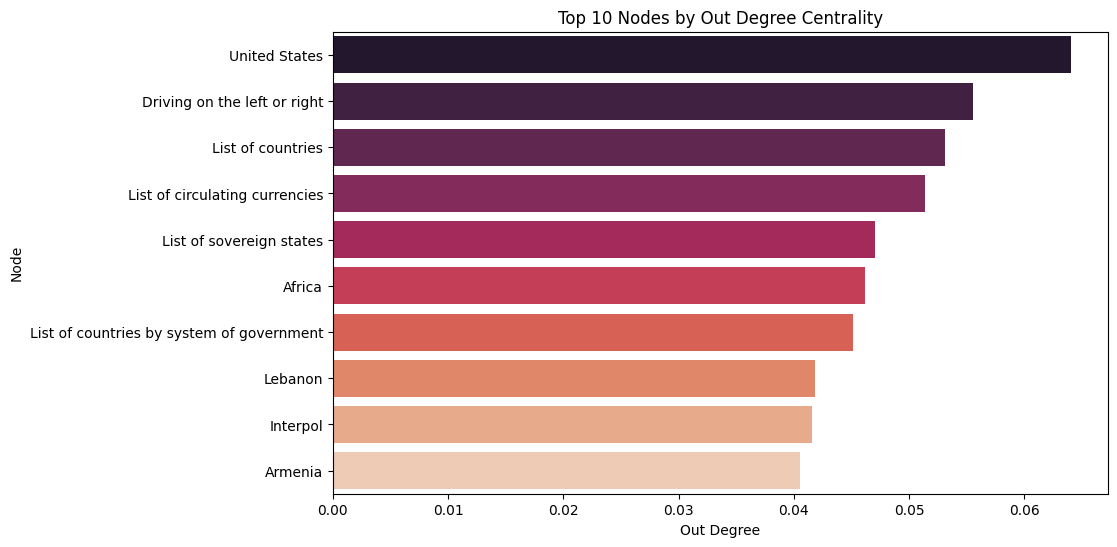

In [18]:
top_out_degree = df_metrics.sort_values(by="out_degree_centrality", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="out_degree_centrality", 
    y="node", 
    data=top_out_degree,
    hue="node",
    palette="rocket"
)
plt.xlabel("Out Degree")
plt.ylabel("Node")
plt.title("Top 10 Nodes by Out Degree Centrality")
plt.show()

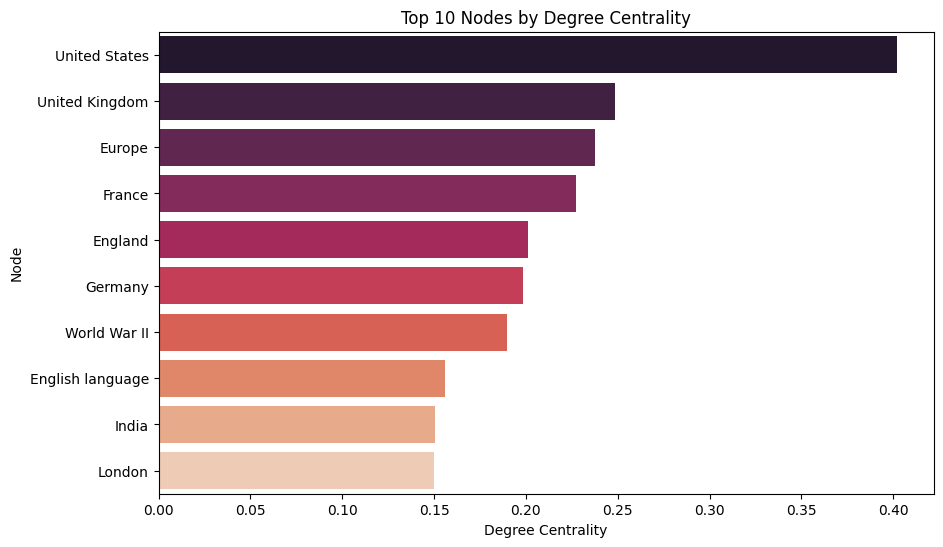

In [19]:
top_degree_centrality= df_metrics.sort_values(by="degree_centrality", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="degree_centrality", 
    y="node", 
    data=top_degree_centrality,
    hue="node", 
    palette="rocket"
)
plt.xlabel("Degree Centrality")
plt.ylabel("Node")
plt.title("Top 10 Nodes by Degree Centrality")
plt.show()

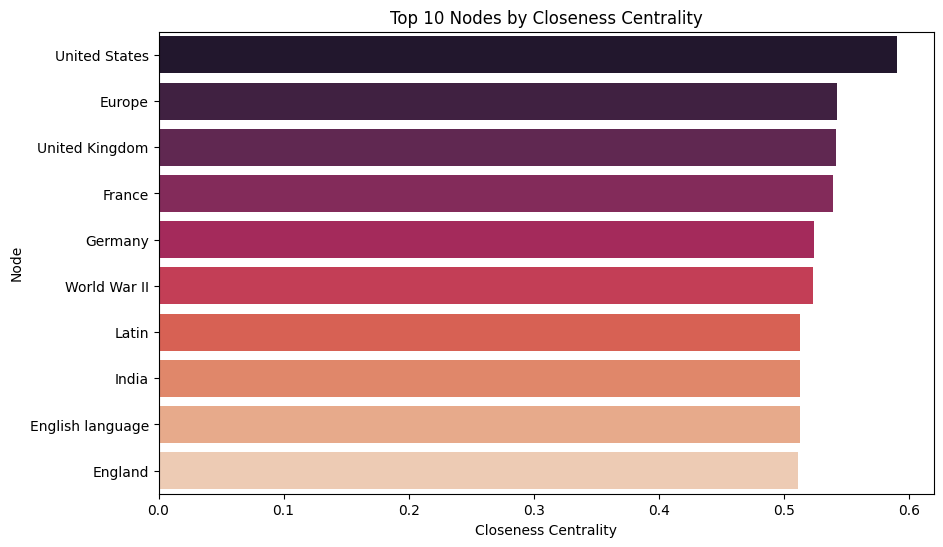

In [20]:
top_closeness_centrality= df_metrics.sort_values(by="closeness_centrality", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="closeness_centrality", 
    y="node", 
    data=top_closeness_centrality,
    hue="node", 
    palette="rocket"
)
plt.xlabel("Closeness Centrality")
plt.ylabel("Node")
plt.title("Top 10 Nodes by Closeness Centrality")
plt.show()

***

# Narrative
Okay, now that we have introduced the dataset and the main research question, let's introduce the two main characters who will accompany us throughout this study: the tough student Pepito and his mentor, Mr. Cajal.

**Pepito**, a young neuroscience student in the class of the prestigious neuroscience class taught by none other than the esteemed **Dr. Ramón y Cajal**, recently found himself in an embarrassing situation.

Last week, Pepito participated in a popular online game known as Wikispeedia a challenge where players try to navigate from one Wikipedia page to a target page in the fewest possible clicks and in the shortest time. However, **Pepito’s performance was, to put it mildly, less than impressive**. He managed to complete only a few paths successfully, often getting lost in the sprawling web of hyperlinks.
When asked about his poor performance, Pepito felt he had no choice but to defend himself. He claimed that his **struggles in the game weren't due to a lack of academic ability, but rather to the game's inherent cognitive difficulty**. He argued that the game presented a high mental fatigue, requiring players to sift through a maze of potential paths across thousands of Wikipedia pages. According to Pepito, the game’s design itself made it easy for anyone, no matter how knowledgeable, to become disoriented. It is all about neuroscience!

Pepito, however, knew that he needed more than just verbal justification to defend his theory in front of Dr. Cajal. Recognizing the skepticism his claim might invite, **he resolved to back it up with solid data analysis**. His hope was to prove statistically that the game was challenging enough to lead even a skilled player into cognitive overload, validating his own struggles.

Dr. Cajal, familiar with Pepito’s poor academic record, was not entirely convinced by this argument. Dr. Cajal tried to refute the thesis of Pepito and he encouraged Pepito to a deeper engagement with his studies and his own academic potential.

What follows is a summary of the spirited discussion that took place between Pepito and Dr. Cajal, along with the data Pepito and Dr Cajal gathered and analyzed to make their cases. 

**Pepito’s research explores whether the cognitive fatigue involved in the Wikispeedia game is indeed as overwhelming as he claims or if, as Dr. Cajal suspects, no real influence is present.**


***

# Pepito's Incipit: Humans are inefficient, but how much?

<span style="color: blue;">**Pepito:**</span>

I begin my defense by arguing that humans are far from finding the optimal solution in a game of WikiSpeedia. Our brains, I believe, are inherently susceptible to cognitive biases that shape and influence our decision-making. To support my thesis, I point out that the average path length found by humans between the target and source nodes in the network is much longer compared to the shortest path that can be determined using algorithms like Breadth-First Search (BFS). This inefficiency, in my view, reflects the limitations of human cognition—an inherent aspect of how our brains process information, which often leads us to make suboptimal choices.

In [21]:
#load aggregated metrics of human played finished games
df_agg_human_played_finished = pd.read_csv("data/output/graph_data/aggregated_human_played_finished.csv", index_col=0)


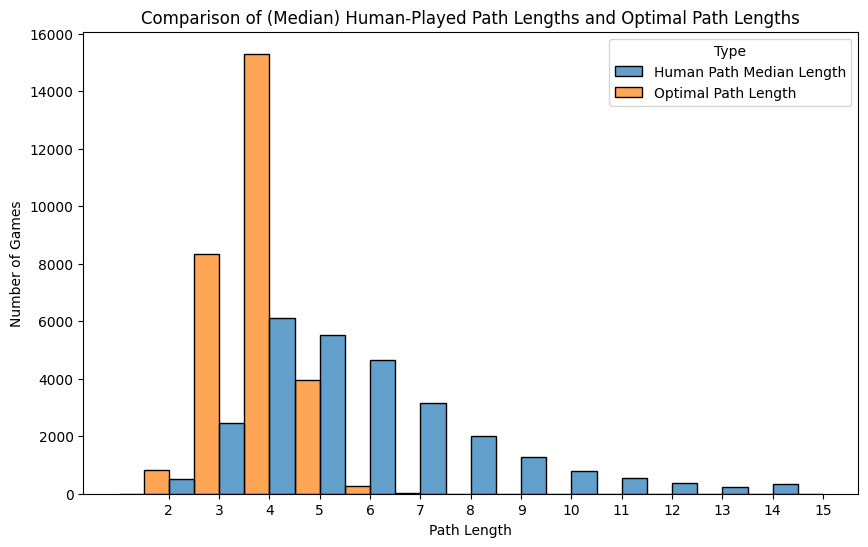

In [22]:
# We are only displaying path lengths of up to 15 as there are some outliers that skew the plot.
human_lengths = df_agg_human_played_finished[df_agg_human_played_finished["median_path_length"] <= 15]["median_path_length"]
optimal_path_lengths = df_agg_human_played_finished["optimal_path_length"]
# NEED TO put all in one df to get a side by side in seaborn
path_lengths_df = pd.DataFrame({
    "path_length": pd.concat([human_lengths, optimal_path_lengths], ignore_index=True),
    "Type": ["Human Path Median Length"] * len(human_lengths) + ["Optimal Path Length"] * len(optimal_path_lengths)
})

plt.figure(figsize=(10, 6))
sns.histplot(data=path_lengths_df, x="path_length", hue="Type", multiple="dodge", binwidth=1, alpha=0.7)

# Labels and title
plt.xlabel("Path Length")
plt.ylabel("Number of Games")
plt.xticks(range(2,16))
plt.title("Comparison of (Median) Human-Played Path Lengths and Optimal Path Lengths")

plt.show()

In [23]:
# how different are the median and the optimal path lengths?
df_agg_human_played_finished['median_diff_from_optimal'] = (df_agg_human_played_finished['median_path_length'] - df_agg_human_played_finished['optimal_path_length'])
overall_median_diff = df_agg_human_played_finished['median_diff_from_optimal'].median()
print("The overall MEDIAN difference of human played games from optimal path length is ", overall_median_diff)

overall_median_optimal_path_length = df_agg_human_played_finished['optimal_path_length'].median()
overall_median_human_path_length = df_agg_human_played_finished['median_path_length'].median()
print("Overall median human path length: ", overall_median_human_path_length)
print("Overall median optimal path length: ", overall_median_optimal_path_length)

The overall MEDIAN difference of human played games from optimal path length is  3.0
Overall median human path length:  5.5
Overall median optimal path length:  3.0


<span style="color: blue;">**Pepito:**</span>

*The overall median difference of human played games from optimal path length is 3!*
This means that in general, human paths are 3 steps longer than the optimal, indicating a measurabe inefficiency in human navigation within Wikispeedia. Looking at the overall median human path length of 5.5, against the median optimal path length, we could even say that human paths are nearly **double** the optimal path length!

<span style="color: red;">**Dr. Cajal:**</span>

Your observation is valid, Pepito, but there are some important points to consider. First, while the median path length in the human game is indeed about three steps longer than the median optimal solution, this gap is still relatively small given the circumstances. While algorithms like BFS can search the entire network and determine the optimal path, humans do not have access to the full structure of the network. This limitation places humans at a significant disadvantage, as we are constrained by incomplete information during decision-making. Second, consider that Wikispeedia network has 4,592 nodes and 119,882 edges and is sparsely connected, navigating through this network is inherently challenging! Given these structural constraints, a 3 step deviation from the optimal path is actually quite small and impressive... in contrast to your performance, Pepito.

# Pepito's Simple Mental Fatigue Metrics

Please refer to [this notebook](src/notebooks/2_time_length.ipynb) for more details.

<span style="color: blue;">**Pepito:**</span>

We all know that tasks that are repeated for long periods or become too complex can lead to confusion and, ultimately, cognitive fatigue. This is what I aim to demonstrate: that both the time taken to complete a path and the length of the path itself play a significant role in gameplay.

Since paths can either be completed or left unfinished, I base my argument on the assumption that unfinished paths are often a result of difficulty and the increased cognitive load experienced by the player during the process.

I will now show that these two factors—time and path length—are important indicators of cognitive strain in gameplay.

### Path Duration

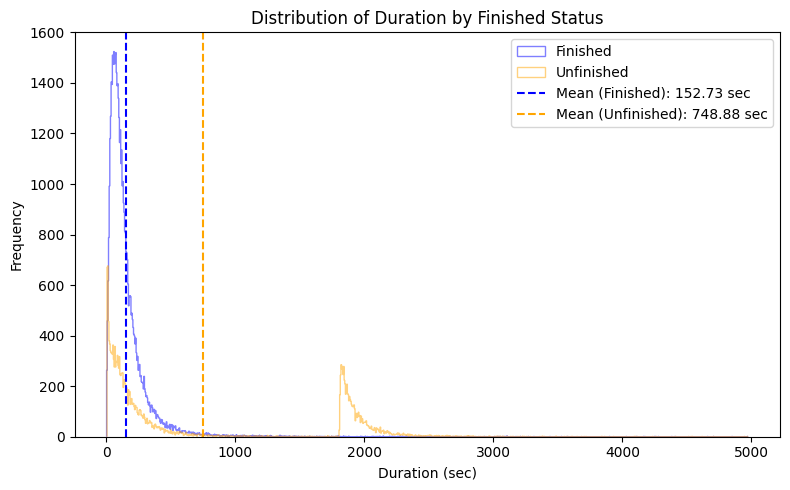

In [24]:
n_bins = 1000

# Separate data into finished and unfinished paths
finished_data = df_path[df_path["finished"] == True]["duration"]
unfinished_data = df_path[df_path["finished"] == False]["duration"]

# Plot the histogram: Duration by Finished Status
plt.figure(figsize=(8, 5))

# Plot the histogram for finished paths
plt.hist(finished_data, bins=n_bins, alpha=0.5, label='Finished', color='blue', histtype='step')

# Plot the histogram for unfinished paths
plt.hist(unfinished_data, bins=n_bins, alpha=0.5, label='Unfinished', color='orange', histtype='step')

# Calculate the mean durations
mean_duration_finished = finished_data.mean()
mean_duration_unfinished = unfinished_data.mean()

# Add vertical lines for the mean durations
plt.axvline(mean_duration_finished, color='blue', linestyle='--', label=f'Mean (Finished): {mean_duration_finished:.2f} sec')
plt.axvline(mean_duration_unfinished, color='orange', linestyle='--', label=f'Mean (Unfinished): {mean_duration_unfinished:.2f} sec')

# Add title, labels, and legend
plt.title("Distribution of Duration by Finished Status")
plt.xlabel("Duration (sec)")
plt.ylabel("Frequency")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

<span style="color: blue;">**Pepito:**</span>

See, the mean duration of unfinished paths (orange line) is much higher compared to finished paths. This means time spent is a reliable predictor of the cognitive load on the person, and thus, the rate of abandonment.


<span style="color: red;">**Dr. Cajal:**</span>

Pepito, please!!! Don’t you see what a strange distribution you have? What about the tail for unfinished paths? Here, have a look. If I now take **only unfinished** paths and color them by the type of unfinished path, i.e., "abandonment" or "timeout," I can clearly see a distinct split. We cannot conclude that unfinished paths indicate higher cognitive load based solely on time spent.  

The increased mean duration in these cases is largely due to session timeouts. In these instances, players were not necessarily experiencing difficulty; rather, they abandoned the session, allowing time to accumulate passively. As a result, the prolonged durations in unfinished paths reflect a lapse in activity rather than active engagement or cognitive load. Thus, any assumptions about cognitive load based on these time differences would be unreliable.


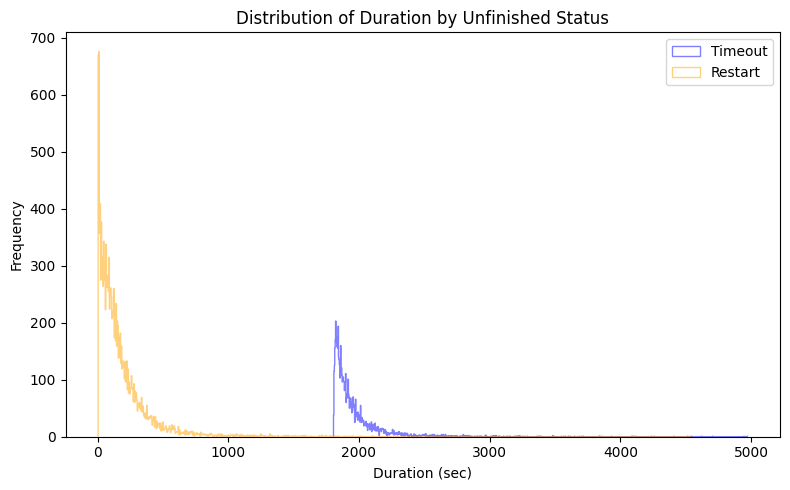

In [25]:
# Filter data for unfinished paths
unfinished_data = df_path[df_path["finished"] == False]

# Separate data into timeout and restart types
unfinished_data_timeout = unfinished_data[unfinished_data["type_unfinished"] == "timeout"]
unfinished_data_restart = unfinished_data[unfinished_data["type_unfinished"] == "restart"]

# Plot the histogram
plt.figure(figsize=(8, 5))

# Plot the histogram for timeout paths
plt.hist(unfinished_data_timeout["duration"], bins=n_bins, alpha=0.5, label='Timeout', color='blue', histtype='step')

# Plot the histogram for restart paths
plt.hist(unfinished_data_restart["duration"], bins=n_bins, alpha=0.5, label='Restart', color='orange', histtype='step')

# Add title, labels, and legend
plt.title("Distribution of Duration by Unfinished Status")
plt.xlabel("Duration (sec)")
plt.ylabel("Frequency")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Path Length

As longer paths mean more articles visited, this could lead to confusion in the player's mind. Perhaps is this a cause of path abandonment?

<span style="color: red;">**Dr. Cajal:**</span>

As you talked about path duration, let me now talk about path length. If path length, as you suppose, could influence the gameplay (i.e., longer paths are correlated to unfinished paths), I should observe that unfinished paths have a higher number of articles visited.


### Distribution of Path lenghts for Finish vs Unfinished paths

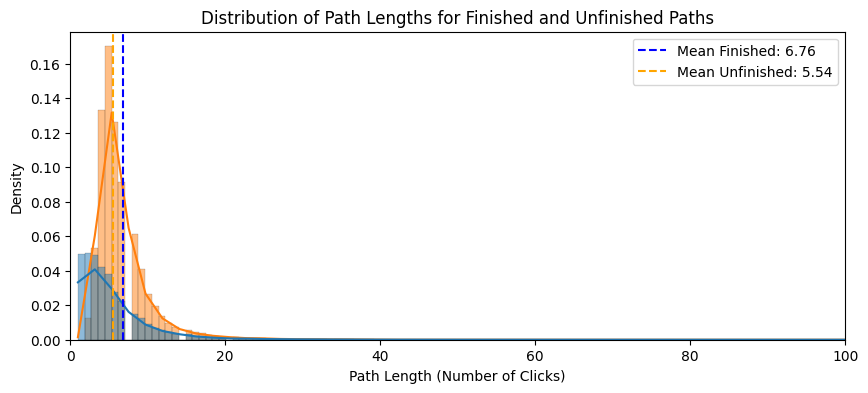

Mann-Whitney U test results for Finished vs. Unfinished Path Lengths: U = 772366749.0, p-value = 0.0


In [26]:
###################################
# Plot distributions
###################################

# Separate data into finished and unfinished paths
finished_paths = df_path[df_path['finished'] == True]
unfinished_paths = df_path[df_path['finished'] == False]

# Plot distribution of path lengths
plt.figure(figsize=(10, 4))
sns.histplot(df_path, x='n_click', hue='finished', kde=True, bins=500, stat="density")

# Plot vertical lines at the means of finished and unfinished paths
mean_finished = finished_paths['n_click'].mean()
mean_unfinished = unfinished_paths['n_click'].mean()
plt.axvline(mean_finished, color='blue', linestyle='--', label=f'Mean Finished: {mean_finished:.2f}')
plt.axvline(mean_unfinished, color='orange', linestyle='--', label=f'Mean Unfinished: {mean_unfinished:.2f}')

# Titles and labels
plt.title('Distribution of Path Lengths for Finished and Unfinished Paths')
plt.xlabel('Path Length (Number of Clicks)')
plt.ylabel('Density')
plt.xlim(0, 100)
plt.legend()
plt.show()

###################################
# Perform Mann-Whitney U test
###################################

finished_lengths = df_path[df_path['finished'] == True]['n_click']
unfinished_lengths = df_path[df_path['finished'] == False]['n_click']
u_stat, p_value = mannwhitneyu(finished_lengths, unfinished_lengths)
print(f"Mann-Whitney U test results for Finished vs. Unfinished Path Lengths: U = {u_stat}, p-value = {p_value}")

<span style="color: red;">**Dr. Cajal:**</span>

As you can see, and as further validated by the **Mann-Whitney U Test**, your thesis is completely contradicted. **Unfinished paths actually have shorter lengths**.

Dr. Cajal decided to use the Mann-Whitney U Test because the normality assumption is not met. It is a non-parametric test used to compare the distributions of two independent groups. Instead of comparing means, the test compares the ranks of values across both groups. The test statistic calculated is:
$$
U = R_1 - \frac{n_1(n_1 + 1)}{2}
$$

Where:
- \( U \) is the Mann-Whitney U statistic.
- \( R_1 \) is the sum of the ranks for group 1.
- \( n_1 \) is the number of observations in group 1.


<span style="color: blue;">**Pepito:**</span>

Mr. Cajal, I think your analysis is not entirely correct. Indeed, it may be that, by chance, finished paths have a source and target link that, by the architecture of the network, are far from each other. As a result, the path is elongated due to this structural factor.

<span style="color: red;">**Dr. Cajal:**</span>

Pepito, you are right, but even if I regress out this factor, the conclusion remains the same. Let's take pairs of target and source links that have been played multiple times (for instance, the following four have been played more than 1000 times each). As you can see from the results of the tests, the difference in means between finished and unfinished paths consistently shows that finished paths have a longer path length. However, the confounding factor you cited earlier has already been regressed out.


In [27]:
# Step 1: Identify the last 4 unique combinations based on group size
last_4_combinations = df_path.groupby(by=["source_link", "target_link"]).size().sort_values().tail(4).index

# Step 2: Filter the DataFrame to include only the last 4 combinations
df_last_4_cases = df_path[df_path.set_index(["source_link", "target_link"]).index.isin(last_4_combinations)]

# Step 3: Group by the last 4 combinations and "finished" column, then calculate the mean of 'n_clicks'
df_grouped = df_last_4_cases.groupby(["source_link", "target_link", "finished"])["n_click"].mean().unstack()

# Step 4: Calculate the mean difference and perform t-test
results = []
for (source, target) in last_4_combinations:
    # Filter the data for this (source_link, target_link)
    data = df_last_4_cases[(df_last_4_cases["source_link"] == source) & (df_last_4_cases["target_link"] == target)]
    
    # Separate the clicks for "True" (finished) and "False" (unfinished) paths
    finished_clicks = data[data["finished"] == True]["n_click"]
    unfinished_clicks = data[data["finished"] == False]["n_click"]
    
    # Perform the t-test (assuming unequal variance)
    t_stat, p_value = ttest_ind(finished_clicks, unfinished_clicks, equal_var=False)
    
    # Store the results (mean difference, t-statistic, p-value)
    mean_diff = finished_clicks.mean() - unfinished_clicks.mean()
    results.append({
        "source_link": source,
        "target_link": target,
        "mean_diff": mean_diff,
        "t_stat": t_stat,
        "p_value": p_value
    })

# Step 5: Convert results into a DataFrame
df_results = pd.DataFrame(results)

# Step 6: Display the results
print(df_results)

  source_link target_link  mean_diff     t_stat       p_value
0     Pyramid        Bean   2.679587  11.532746  1.605381e-29
1     Theatre       Zebra   2.740315  14.538996  3.410645e-45
2    Asteroid      Viking   2.478926  13.851010  1.600135e-40
3       Brain   Telephone   2.896909  18.759760  2.702263e-72


# Pepito and Readability Metrics

Please refer to [this notebook](src/notebooks/3_readability.ipynb) for more details.

<span style="color: blue;">**Pepito:**</span>

WikiSpeedia is a game based on articles, specifically written text. Whether the user is willing or unwilling, they are constantly interacting with phrases and words. Previous studies have shown that complex text can lead to mental fatigue, and readability metrics—such as those used to assess the ease of reading—can serve as a proxy to quantify this aspect [(Ref)](https://typeset.io/papers/readability-measures-as-predictors-of-understandability-and-4cc738phts).


Before proceding with the analysis we must define what are readability metrics, and which one we are goin to use:

**Readability metrics measure the ease with which a reader can understand a text.** Factors such as sentence length, word complexity, and the use of technical jargon all contribute to these measurements. Please refer to the realtive notebook to understand in details what each formula represents.

<span style="font-size:28px">Flesch-Kincaid Grade Level:</span>
$$
0.39 \times \left(\frac{\text{total words}}{\text{total sentences}}\right) + 11.8 \times \left(\frac{\text{total syllables}}{\text{total words}}\right) - 15.59
$$

<span style="font-size:28px">Gunning Fog Index:</span>
$$
0.4 \times \left( \left( \frac{\text{total words}}{\text{total sentences}} \right) + \frac{\text{complex words}}{\text{total words}} \times 100 \right)
$$

<span style="font-size:28px">Automated Readability Index (ARI):</span>
$$
4.71 \times \left(\frac{\text{total characters}}{\text{total words}}\right) + 0.5 \times \left(\frac{\text{total words}}{\text{total sentences}}\right) - 21.43
$$

<span style="font-size:28px">SMOG (Simple Measure of Gobbledygook):</span>
$$
1.0430 \times \sqrt{\text{polysyllabic words} \times \left( \frac{30}{\text{total sentences}} \right)} + 3.1291
$$

<span style="font-size:28px">Coleman-Liau Index:</span>
$$
0.0588 \times \left( \frac{\text{total characters}}{\text{total words}} \times 100 \right) - 0.296 \times \left( \frac{\text{total sentences}}{\text{total words}} \times 100 \right) - 15.8
$$

<span style="font-size:28px">Readability Consensus Index:</span>
   - **What it measures:** This combines several readability formulas (like Flesch-Kincaid, Gunning Fog, ARI) into a single score that estimates the overall readability of the text.
   - **How to calculate:** Average the results of different readability formulas to obtain a comprehensive view of the text's accessibility.




In [28]:
df_fatigue = pd.read_csv("data/output/fatigue_metric_data/articles_fatigues_long.csv")

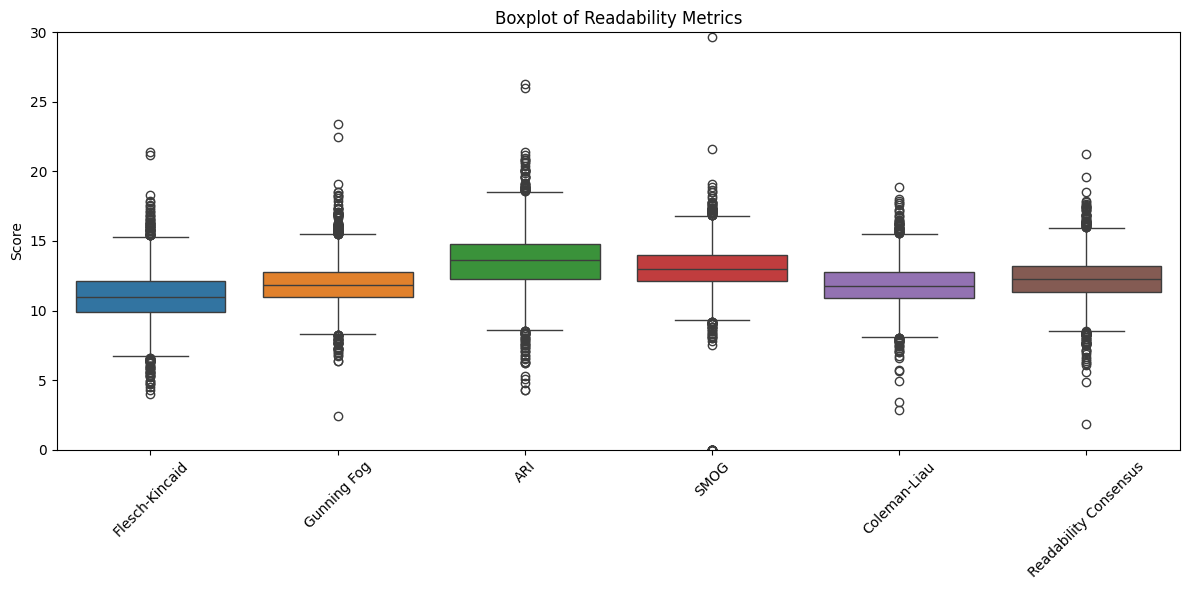

In [29]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Boxplot for readability metrics
sns.boxplot(data=df_fatigue[['Flesch-Kincaid', 'Gunning Fog', 'ARI', 'SMOG', 'Coleman-Liau', 'Readability Consensus']])
plt.title('Boxplot of Readability Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 30)

# Show the plot
plt.tight_layout()
plt.show()


<span style="color: blue;">**Pepito:**</span>

As all the Metrics seems to have the same distribution, I will use mainly the `Readability Consensus` as it is a good middle way between them.

In [30]:
# Calculate aggregate metrics
aggregate_metrics = df_fatigue[['Flesch-Kincaid', 'Gunning Fog', 'ARI', 'SMOG', 'Coleman-Liau', 'Readability Consensus']].agg(['mean', 'median', 'std', 'min', 'max'])

# Display the aggregate metrics
display(aggregate_metrics)

,Flesch-Kincaid,Gunning Fog,ARI,SMOG,Coleman-Liau,Readability Consensus
mean,11.063054,11.911123,13.585404,12.974761,11.823812,12.271631
median,11.000000,11.830000,13.600000,13.000000,11.780000,12.266000
std,1.852231,1.577178,2.131589,1.814130,1.473235,1.593012
min,-0.400000,2.400000,4.300000,0.000000,2.830000,1.826000
max,45.900000,42.830000,59.900000,29.700000,18.880000,39.442000


### Mean Readability per Path

Naturally, Pepito wanted to calculate a more reliable metric for each path, rather than just for individual articles. To do this, he created an overall readability metric by averaging the scores of the readability metrics for each article that made up a given path. (A detailed procedure on how to create the corresponding dataset is reported in the previously cited notebook.)

In [31]:
df_path_fatigue = pd.read_csv("data/output/fatigue_metric_data/path_processed_with_readability.csv",low_memory=False)

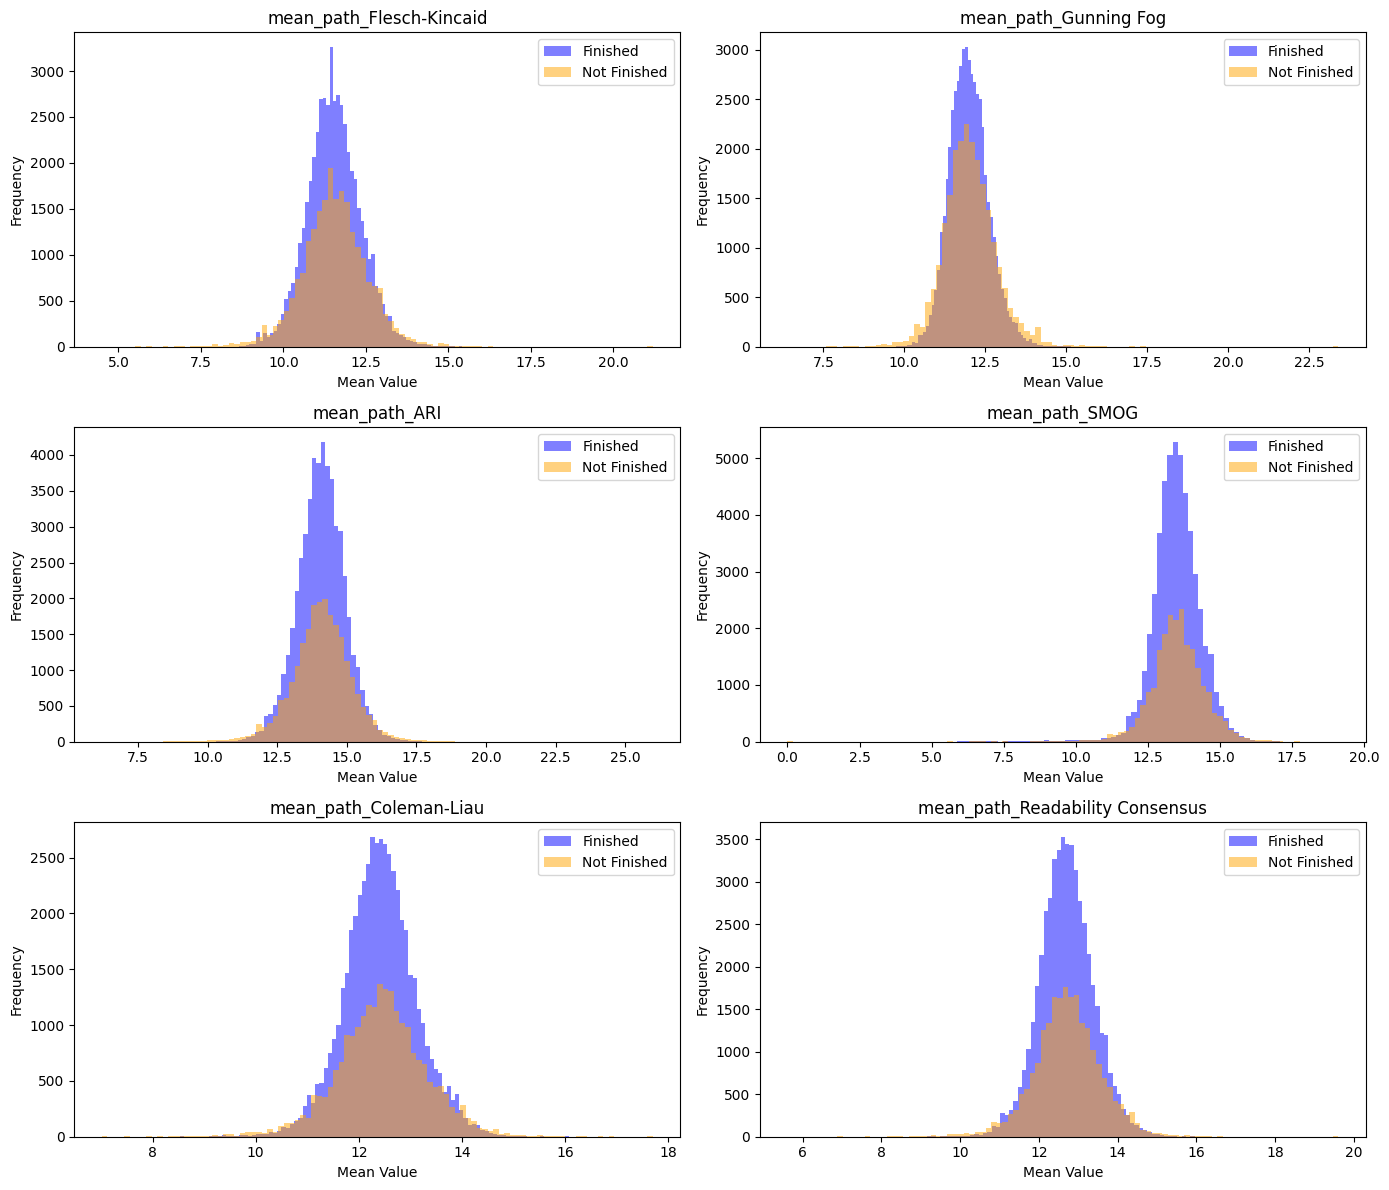

In [32]:
# Set up the figure and axes for the histograms
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# List of metrics to plot
metrics = [
    'mean_path_Flesch-Kincaid',
    'mean_path_Gunning Fog',
    'mean_path_ARI',
    'mean_path_SMOG',
    'mean_path_Coleman-Liau',
    'mean_path_Readability Consensus'
]

# Plot histograms for each metric, split by finished status
for i, metric in enumerate(metrics):
    # Plot for finished == True
    axes[i].hist(df_path_fatigue[df_path_fatigue['finished'] == True][metric], 
                  alpha=0.5, label='Finished', color='blue', bins=100)
    # Plot for finished == False
    axes[i].hist(df_path_fatigue[df_path_fatigue['finished'] == False][metric], 
                  alpha=0.5, label='Not Finished', color='orange', bins=100)
    
    # Labeling
    axes[i].set_title(metric)
    axes[i].set_xlabel('Mean Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

Even though the distribution between finished and unfinished paths seems quite similar, Pepito refuses to give up and wants to perform a t-test to be absolutely sure that there is no significant difference between the two.

**What is a t-test?**
A t-test is a statistical test used to compare the means of two groups to determine if there is a significant difference between them. It helps assess whether the observed differences are due to chance or represent a true effect.

**Assumptions of a t-test**
The t-test assumes that the samples from each group are independent of each other, that the data in each group are approximately normally distributed, and (in the case of a two-sample t-test) that the variances of the two groups are roughly equal.

In [33]:
# Store results
results = {}

metrics = [
    'mean_path_Flesch-Kincaid',
    'mean_path_Gunning Fog',
    'mean_path_ARI',
    'mean_path_SMOG',
    'mean_path_Coleman-Liau',
    'mean_path_Readability Consensus'
]

# Perform t-tests for each metric
for metric in metrics:
    finished_data = df_path_fatigue[df_path_fatigue['finished'] == True][metric]
    not_finished_data = df_path_fatigue[df_path_fatigue['finished'] == False][metric]
    
    t_stat, p_value = ttest_ind(finished_data, not_finished_data, equal_var=False)  # Welch's t-test
    results[metric] = {'t_statistic': t_stat, 'p_value': p_value}

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results).T
results_df['significant'] = results_df['p_value'] < 0.05  # Determine significance

# Display results
print(results_df)

                                 t_statistic   p_value  significant
mean_path_Flesch-Kincaid           -1.697088  0.089689        False
mean_path_Gunning Fog              -4.696039  0.000003         True
mean_path_ARI                      -1.698978  0.089332        False
mean_path_SMOG                     -0.848272  0.396292        False
mean_path_Coleman-Liau             -1.435003  0.151295        False
mean_path_Readability Consensus    -2.181674  0.029140         True


<span style="color: blue;">**Pepito:**</span>


See, it's clear—there is a statistically significant difference in the means of finished and unfinished paths for the Readability Consensus. This clearly shows that readability plays a role in the gameplay of WikiSpeedia.

In [34]:
grouped_means = df_path_fatigue.groupby('finished')['mean_path_Readability Consensus'].mean()
grouped_means

finished
False    12.715505
True     12.700971
Name: mean_path_Readability Consensus, dtype: float64

<span style="color: red;">**Dr. Cajal:**</span>


First of all, you need to understand the **difference between statistical significance and practical significance.**

Statistical significance means that the difference you observed is unlikely to have happened by chance, usually indicated by a p-value less than 0.05. However, practical significance concerns whether this difference is large enough to have a real-world impact. A statistically significant result does not necessarily mean it is meaningful in the context of the game.

Even though your findings might be statistically significant (with a p-value < 0.05), the actual change in means is so small (~0.01) that it would not affect gameplay in any meaningful way. Therefore, these results cannot be used to support your theory, Pepito.

***

# Dr. Cajal's Response: Entropy

Dr. Cajal is growing increasingly frustrated with the weak thesis presented by Pepito and decides to counterattack with a more powerful concept: **Entropy**.

<span style="color: red;">**Dr. Cajal:**</span>

"Dear Pepito, let's examine a more complex metric—the entropy of a path. Entropy, you could say, serves **as an index of indecisiveness and uncertainty**. It helps us understand why some paths are abandoned mid-journey. High entropy suggests that users are navigating across many different articles without a clear direction, likely due to cognitive overload or confusion. In essence, entropy quantifies decision-making uncertainty and can act as a proxy for cognitive load, revealing the challenges that players face as they attempt to complete paths.
If this theory holds—if entropy indeed impacts gameplay—then we should observe higher average entropy per path in unfinished journeys compared to completed ones. **I will show you that this is not the case.**"

Before we proceed, let’s define the metrics we’ll be using in detail (see [notebook](src/notebooks/4_entropy.ipynb) ).

### Article Entropy
**Shannon Entropy**: When an article leads to multiple different subsequent articles with similar probabilities, its entropy will be high. Formally, we define entropy for **a single article** as:

$$
H(X) = -\sum_{i=1}^{n} p(x_i) \log_2 p(x_i)
$$

Where:
- **H(X)** represents the Shannon entropy of the random variable **X**.
- **p(x_i)** is the probability of each possible outcome **x_i** (e.g., the probability of transitioning to a specific subsequent article).
- **n** is the total number of possible outcomes (next articles).

Naturally the Entropy metric will derive from played games and not from the static connectivity of the articles network.

### Path Entropy
**Path Entropy** is the mean entropy of the articles within a path. 


In [35]:
# As usual we are going to only load the pre-conputed data
# For specific pipeline please refer to the relative notebook

entropy_path = pd.read_csv("data/output/entropy_data/entropy_per_path.csv", low_memory=False)
entropy_article = pd.read_csv("data/output/entropy_data/entropy_per_article.csv")
entropy_adj = pd.read_csv("data/output/entropy_data/entropy_adj.csv")
entropy_adj = entropy_adj.set_index("article_name")

<span style="color: red;">**Dr. Cajal:**</span>


Let's make an example. As you can see the Entropy of *Dante Alighieri* is relatively high, due to the relative multiples path that gamers have taken during the past games.

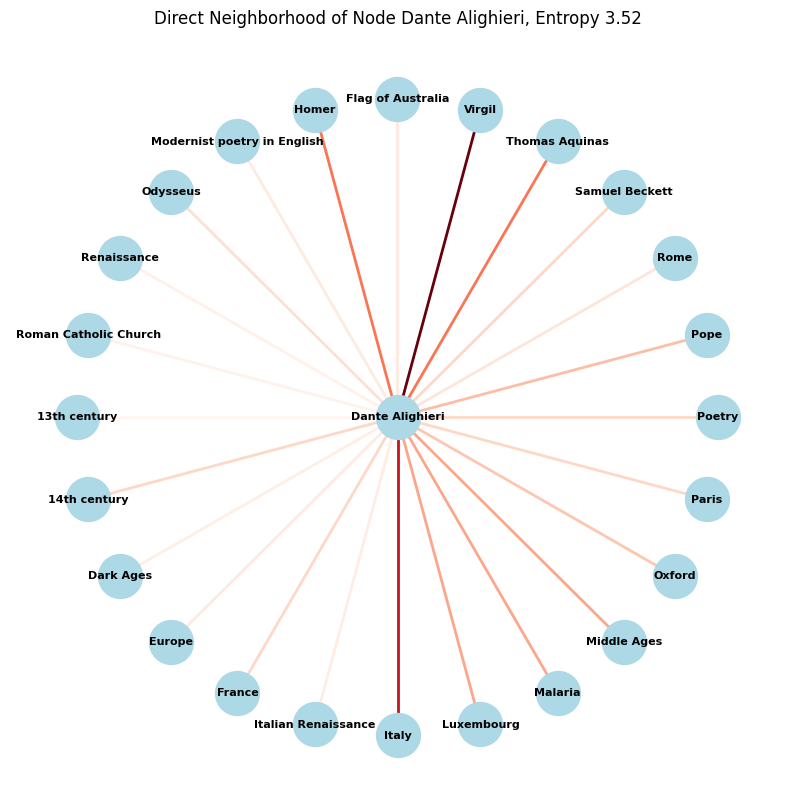

In [36]:
# Select the specific node for which you want to draw its neighborhood
node_of_interest = "Dante Alighieri"  # Replace with the actual node label

# Create the graph from the adjacency matrix
G = nx.from_pandas_adjacency(entropy_adj)

# Get only the edges directly connected to the node_of_interest
ego_edges = [(node_of_interest, neighbor) for neighbor in G.neighbors(node_of_interest)]
ego_subgraph = G.edge_subgraph(ego_edges)  # Create a subgraph with only those edges

# Define positions for the nodes in a star layout (circular around the core)
pos = nx.shell_layout(ego_subgraph, nlist=[[node_of_interest], list(G.neighbors(node_of_interest))])

# Get edge weights and map them to colors on a heatmap
edge_weights = np.array([G.edges[edge]['weight'] for edge in ego_edges])
norm = plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max())  # Normalize weights for color mapping
edge_colors = [cm.Reds(norm(weight)) for weight in edge_weights]  # Map weights to colors using colormap

# Draw the subgraph with scaled edge colors based on weights
fig, ax = plt.subplots(figsize=(10,10))
fig.patch.set_facecolor('black')  # Set the background color of the entire figure to black
ax.set_facecolor('black')  # Set the plot area background to black

nx.draw(
    ego_subgraph,
    pos,
    with_labels=True,
    node_size=1000,
    node_color='lightblue',
    font_size=8,
    font_weight='bold',
    edge_color=edge_colors,  # Use color map for edge colors
    width=2,  # Set a fixed width for better visibility
    ax=ax     # Draw on the specified axis
)

# Set the title with white font color for visibility on black background
plt.title(f'Direct Neighborhood of Node {node_of_interest}, Entropy {entropy_article[entropy_article["article_name"] == node_of_interest]["entropy"].values[0]:.2f}', color='black')
plt.show()


<span style="color: red;">**Dr. Cajal:**</span>

Firslty observe that there is almost no correlation (~0.19) between unfinished and the mean entropy per path, signifying no relationship between the two.

We are going ot use the metric: **Point-Biserial Correlation** which measures the strength and direction of the relationship between a binary categorical variable and a continuous variable. It is a special case of the Pearson correlation when one variable is binary (0 or 1) and the other is continuous.
$$
r_{pb} = \frac{M_1 - M_0}{s} \cdot \sqrt{\frac{n_1 n_0}{n(n - 1)}}
$$

Where:
- \( M_1 \) = mean of the continuous variable for the group with label 1
- \( M_0 \) = mean of the continuous variable for the group with label 0
- \( s \) = standard deviation of the continuous variable
- \( n_1 \) = number of observations with label 1
- \( n_0 \) = number of observations with label 0
- \( n \) = total number of observations



In [37]:
# Assuming `category` is binary (0/1) and `continuous_var` is the continuous variable
correlation, p_value = pointbiserialr(entropy_path["finished"], entropy_path["entropy_path"])
print(f"Point-Biserial Correlation: {correlation}, p-value: {p_value}")


Point-Biserial Correlation: 0.19409625942219272, p-value: 0.0


<span style="color: red;">**Dr. Cajal:**</span>

Secondly, it is important to note that there is a significant difference in the means of finished and unfinished paths (calculated using a t-test), but interestingly, this difference favors the unfinished paths. Therefore, your hypothesis that higher entropy is associated with abandonment is not only incorrect, but actually completely reversed. **People who succeed tend to follow paths with higher entropy. In essence, they are seeking complexity.**

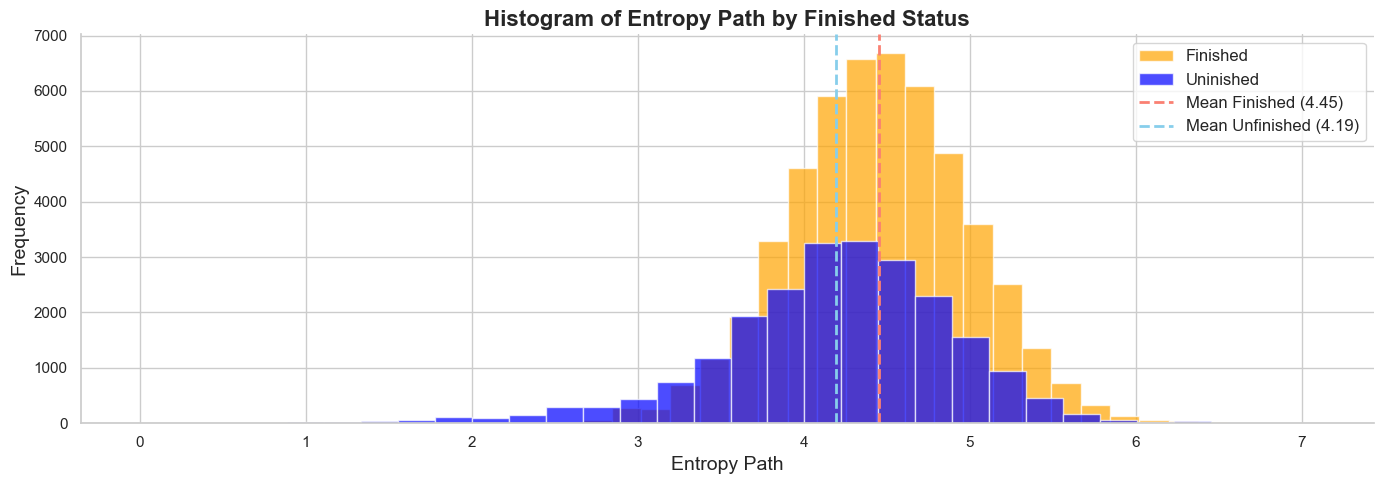

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate means for both finished categories
mean_finished_1 = entropy_path[entropy_path['finished'] == 1]['entropy_path'].mean()
mean_finished_0 = entropy_path[entropy_path['finished'] == 0]['entropy_path'].mean()

# Set the Seaborn style for an elegant appearance
sns.set_theme(style="whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(14, 5))  # Larger figure size for better visibility

# Plot histograms with gradient-like color schemes
colors = sns.color_palette("coolwarm", as_cmap=True)
ax.hist(entropy_path[entropy_path['finished'] == 1]['entropy_path'].dropna(), bins=30, alpha=0.7, color='orange', label='Finished', edgecolor='white')
ax.hist(entropy_path[entropy_path['finished'] == 0]['entropy_path'].dropna(), bins=30, alpha=0.7, color='blue', label='Uninished', edgecolor='white')

# Plot vertical lines for the means
ax.axvline(mean_finished_1, color='salmon', linestyle='dashed', linewidth=2, label=f'Mean Finished ({mean_finished_1:.2f})')
ax.axvline(mean_finished_0, color='skyblue', linestyle='dashed', linewidth=2, label=f'Mean Unfinished ({mean_finished_0:.2f})')


# Set plot title and labels with improved fonts
ax.set_title('Histogram of Entropy Path by Finished Status', fontsize=16, fontweight='bold')
ax.set_xlabel('Entropy Path', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

# Display the legend with a cleaner style
ax.legend(frameon=True, fontsize=12, loc='upper right')

# Remove top and right spines for a modern look
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()


In [39]:
# Separate the groups based on the 'finished' column
group1 = entropy_path[entropy_path['finished'] == 1]['entropy_path'].dropna()  # Group where finished = 1
group2 = entropy_path[entropy_path['finished'] == 0]['entropy_path'].dropna()  # Group where finished = 0

# Perform an independent t-test
# ATTENTION: from the hist of above the data seems gaussian
t_stat, p_value = ttest_ind(group1, group2, equal_var=True)  # Use equal_var=False for Welch's t-test

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: The means are significantly different.")
else:
    print("Fail to reject the null hypothesis: The means are not significantly different.")

T-statistic: 53.86419551049631
P-value: 0.0
Reject the null hypothesis: The means are significantly different.


<span style="color: blue;">**Pepito:**</span>

Your analysis is correct, but it doesn’t quite make sense to me. Based on your findings, it seems that people are **intentionally seeking out articles with higher entropy**, almost as if they enjoy engaging with more chaotic content. This is a very strange behavior, and I would appreciate it if you could explain why this happens. At this moment, I remain skeptical about your conclusion.

# Dr. Cajal Clarifies Pepito's Concerns: Connectivity Analysis

Please refer to the [notebook](src/notebooks/5_graph_analysis.ipynb).

<span style="color: red;">**Dr. Cajal:**</span>

I think players aren’t navigating randomly or chaotically but are actually following a clever gaming strategy. I’ll show you that, in reality, they’re actively seeking high-connectivity hubs to efficiently reach their target article. This isn’t aimless clicking—it’s strategic thinking, Pepito!

In [40]:
df_metrics = pd.read_csv('data/output/graph_data/all_connections_graph_metrics.csv')

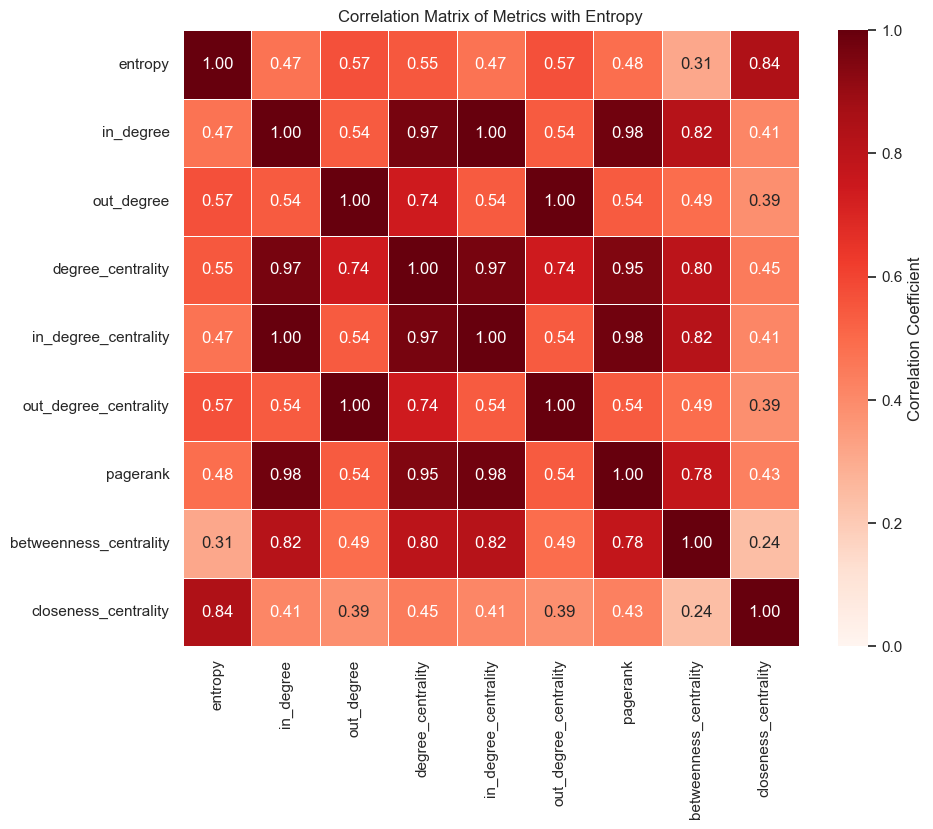

In [41]:
# compute the Pearson correlation coefficients to see the correlation between entropy and all the other metrics we have available
correlation_matrix = df_metrics[['entropy', 'in_degree', 'out_degree', 'degree_centrality',
                         'in_degree_centrality', 'out_degree_centrality',
                         'pagerank', 'betweenness_centrality', 'closeness_centrality']].corr(method='pearson')

#print("\nCorrelation Matrix:")
#print(correlation_matrix['entropy'])
#display a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))

# Plot the heatmap with annotations for better readability
sns.heatmap(correlation_matrix, 
            annot=True,        
            fmt=".2f",          
            cmap="Reds",    
            cbar_kws={'label': 'Correlation Coefficient'}, 
            square=True,       
            linewidths=0.5,
            vmin=0, vmax=1)    

# Add title
plt.title("Correlation Matrix of Metrics with Entropy")

# Show plot
plt.show()

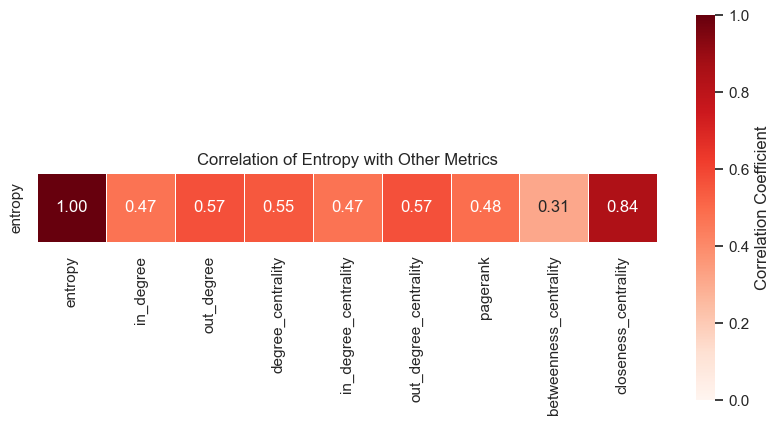

In [42]:
#show  vector only for entropy with other metrics
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix[['entropy']].T, 
            annot=True, 
            fmt=".2f", 
            cmap="Reds", 
            cbar_kws={'label': 'Correlation Coefficient'}, 
            square=True, 
            linewidths=0.5,
            vmin=0, vmax=1)
plt.title("Correlation of Entropy with Other Metrics")
plt.show()

<span style="color: red;">**Dr. Cajal:**</span>

As you can see, entropy is positively correlated with all connectivity indices, indicating that, in this case, entropy should not be interpreted as a proxy for indecision. Instead, it works as an indirect measure of the connectivity of the articles that players are navigating.

In simple terms, an article with high entropy doesn't necessarily indicate that players are taking various different links from it (which would show high uncertainty in their choices). Instead, it just means that some articles naturally have more outgoing links than others, which inflates the entropy value.

Additionally, the highest correlation is found with closeness centrality, which makes perfect sense, as players tend to select articles that are highly connected, helping them move efficiently from any starting article to the intended target.

Let’s look into the details of this fascinating metric:

### Closeness centrality has highest correlation to Entropy

Closeness centrality measures how close a node is to all other nodes in the graph. It is based on the *average shortest path distance* from a given node to all other nodes that can be reached. A node with high closeness centrality reaches other nodes more quickly, which can indicate a high degree of accessibility within the graph.

For a node $ u $, the closeness centrality $ C(u) $ is calculated as:

$$
C(u) = \frac{N - 1}{\sum_{v \neq u} d(u, v)}
$$

where:
- \( N \) is the total number of nodes in the graph.
- \( d(u, v) \) is the shortest path distance between nodes \( u \) and \( v \).


In summary, if a node has high closeness centrality, it means that the node is "closer" to other nodes on average. A lower closeness centrality means the node is on average, farther from other nodes in the graph in terms of path length.


After closeness centrality, out_degree and degree_centrality have the highest correlation to entropy.
Nodes with higher outgoing connections have higher entorpy. Outgoing connection influene entropy more than incoming connections becasue entorpy could be related to a nodes hability to link "out" to many other node and giving more options.
Degree centrality is another measure of how well connected a node is. On a graph $ G $, networkX calculates the degree centrality as:

$$
C(u) = \frac{\text{deg}(u)}{N - 1}
$$

where:
- $ \text{deg}(u) $ is the degree (number of edges) of node $ u $.
- $ N $ is the total number of nodes in the graph.


Nodes with higher entropy also tend to be more "central" overall in terms of connections when considering incoming and outgoing connections.

These 3 metrics and their high correlation to entropy suggest that node with high entorpy are generally central and well connected in the graph...

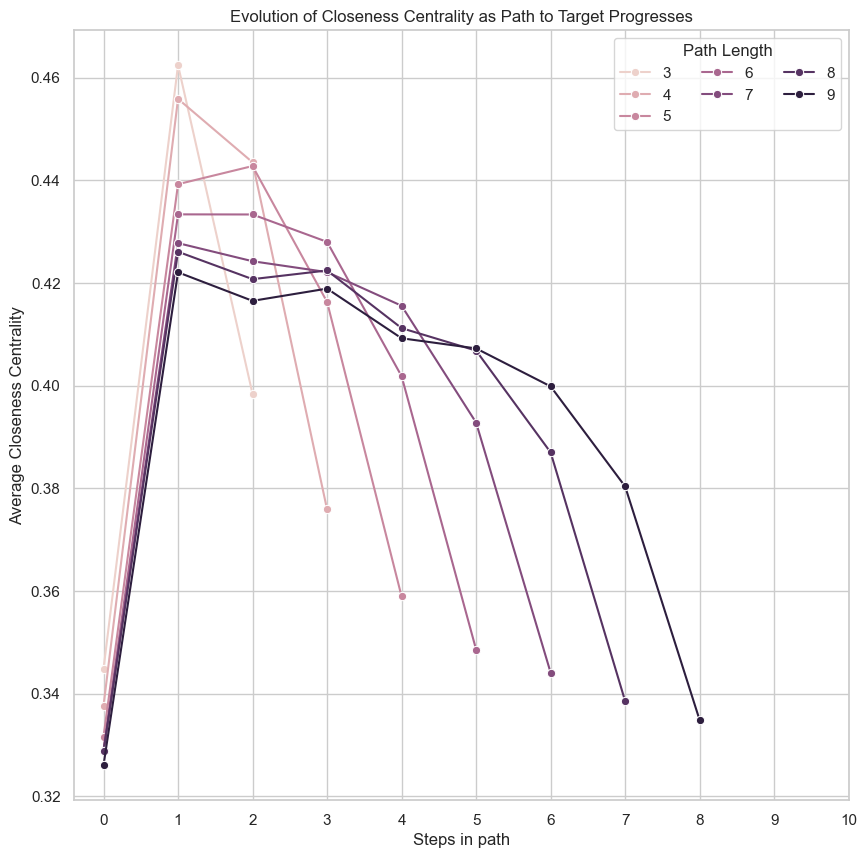

In [43]:
df_filt_avg_od_cc = pd.read_csv('data/output/graph_data/filtered_aggregated_step_avgs.csv')
plt.figure(figsize=(10,10))

sns.lineplot(data=df_filt_avg_od_cc, x='step_in_path', y='avg_closeness_centr', hue='path_length', hue_order=range(2, 11), marker='o', err_style='bars')

# # Manually adding error bars with plt.errorbar cuz seabnr is weird (nvm they look ugly)
# for path_length in df_filt_avg_od_cc['path_length'].unique():
#     subset = df_filt_avg_od_cc[df_filt_avg_od_cc['path_length'] == path_length]
#     plt.errorbar(
#         subset['step_in_path'], subset['avg_closeness_centr'], 
#         yerr=subset['std_closeness_centr'], fmt='o', capsize=5, label=f'Path Length {path_length}'
#     )
plt.xlabel("Steps in path")
plt.xticks(range(0,11))
plt.ylabel("Average Closeness Centrality")
plt.legend(
    title="Path Length", 
    loc="upper right",
    ncol=3
)
plt.title("Evolution of Closeness Centrality as Path to Target Progresses")

plt.show()

<span style="color: red;">**Dr. Cajal:**</span>

You can even see, Pepito, that players tend to seek high-connectivity nodes early in their paths! The graph clearly shows how closeness centrality spikes at the beginning, indicating that players prioritize **well-connected articles right from the start**. This initial strategy helps them quickly move toward their target, rather than wandering aimlessly. **It’s proof that their choices are strategic, not chaotic!**

# Pepito's new hope: Cognitive Shifting

Despite being taken aback by the strong evidence presented by the Professor, Pepito will not be deterred so easily. 
Cajal's mention of strategic choices along a path gives Pepito a new idea: measuring the **amount of change** along a path.
He decides to try a new metric, **cognitive shifting**.

## Category Shift

Please refer to the [notebook](src/notebooks/6_cognitive_shift.ipynb).

<span style="color: blue;">**Pepito:**</span>


When alternative, task-unrelated stimuli are presented to a human, mental fatigue and attention are negatively impacted <https://pubmed.ncbi.nlm.nih.gov/26752733/>.
I believe that **moving from one category of knowledge to another** (e.g., from science-related articles to arts-related articles) **requires cognitive shifting**, which can **negatively impact gameplay**.
For each path, I will count the **category changes**, for example if the player is on an article categorised "Science" and moves to an article categorised "History", this represents a category change.
I will only select paths of length more than 3, as shorter paths do not have enough changes for the mental fatigue to be of any significance.
I will also remove the last shift of finished paths, as this is a necessary to get to the target articles's category.

In [44]:
df_category_shift = pd.read_csv("data/output/cognitive_shift_data/paths_category_shift.csv", low_memory=False)

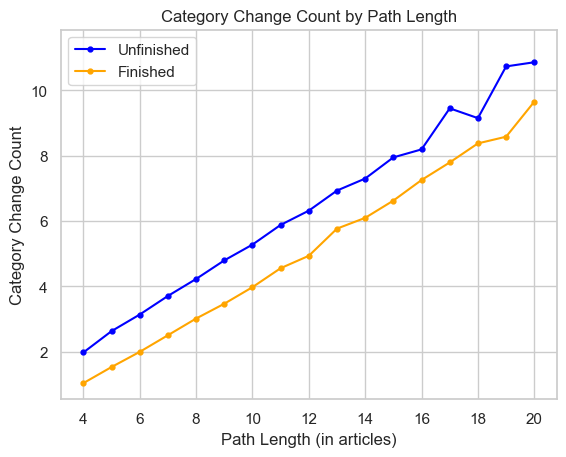

In [45]:
# max path length we want to plot
max_x = 20

# filter by finished status and path length
df_paths_finished = df_category_shift[df_category_shift["finished"] == True]
df_paths_unfinished = df_category_shift[df_category_shift["finished"] == False]

df_paths_finished = df_paths_finished[df_paths_finished["n_click"] <= max_x]
df_paths_unfinished = df_paths_unfinished[df_paths_unfinished["n_click"] <= max_x]

# group by path length
finished_category_change = df_paths_finished.groupby("n_click")["category_change_count"].mean().reset_index()
unfinished_category_change = df_paths_unfinished.groupby("n_click")["category_change_count"].mean().reset_index()

plt.plot(unfinished_category_change["n_click"], unfinished_category_change["category_change_count"], marker = ".", markersize = 7, label="Unfinished", color="blue")
plt.plot(finished_category_change["n_click"], finished_category_change["category_change_count"], marker = ".", markersize = 7, label="Finished", color="orange")

plt.ylim(None, max(finished_category_change["category_change_count"].max(), unfinished_category_change["category_change_count"].max()) + 1)

plt.title("Category Change Count by Path Length")
plt.xlabel("Path Length (in articles)")
plt.ylabel("Category Change Count")

plt.legend()
plt.show()

In [46]:
finished_counts = df_category_shift[df_category_shift["finished"] == True]["category_change_count"]
not_finished_counts = df_category_shift[df_category_shift["finished"] == False]["category_change_count"]

t_stat, p_value = ttest_ind(finished_counts, not_finished_counts, equal_var=False)  # Use Welch's t-test

alpha = 0.05  # Significance level
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of the two groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the two groups.")

T-statistic: -50.690
P-value: 0.000
Reject the null hypothesis: There is a significant difference between the means of the two groups.


<span style="color: blue;">**Pepito:**</span>

*Maravilloso!*, the category shift per link **is higher in unfinished paths** which shows that a higher shift correlates with increased cognitive load and thus greater difficulty.

<span style="color: red;">**Dr. Cajal:**</span>

Indeed that seems to be the case, however **are you sure that changes in category is the best metric for measuring cognitive shifting**?
Articles who have the same category could be completely unrelated, take for example Alexander the Great and Einstein.
These two articles have category "People" but have close to nothing in common.
Now take Einstein and Physics, these articles have category "People" and "Physics" respectively, but are very closely related.
Furthermore, are you sure you should be removing the final shift in finished paths?
It is necessary, but still represents a change in category that should be accounted for if we consider cognitive load.
Furthermore, this is only applied to finished paths, but unfinished paths might also have this necessary shift.

## Semantic shift


<span style="color: blue;">**Pepito:**</span>

A potentially more meaninigul metric I can use is **semantic shift**, which I define as one minus the semantic similarity between two successive articles.
**Large semantic shifts** between articles can represent a **higher cognitive load** for the player, having to completely change topics from one article to the other.
I can investigate if this is related to whether the path is finished or not.

In [47]:
df_semantic_shift = pd.read_csv("data/output/cognitive_shift_data/paths_semantic_shift.csv", low_memory=False)

#### Little Example

**Semantic similarity** refers to the degree to which two concepts, words, or phrases are related in meaning, even if they are not identical.
In essence, it allows us to evaluate **how similar words or sentences based on their meanings** rather than exact matches.
To quantify this value, Pepito is going to use **SentenceTransformer** a model that specializes in measuring semantic similarity by transforming sentences or words into high-dimensional vectors, which then allows for easy comparison of their meanings.

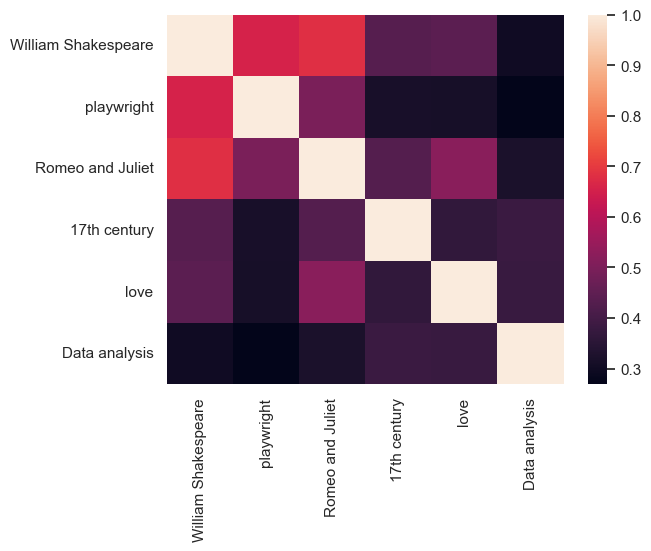

In [48]:
df_example_similarity = pd.read_csv("data/output/cognitive_shift_data/example_similarity.csv", index_col=0)

sns.heatmap(df_example_similarity)
plt.show()

To ensure he understands how this metric works, Pepito is testing the model on a subset of words.
The results are **generally intuitive**: for example, "William Shakespeare" is semantically close to terms like "playwright" and "Romeo and Juliet" but has no relationship to "data analysis."
However, **the model isn't perfect**; it struggles with more nuanced relationships, such as between "Romeo and Juliet" and "love," which one might expect to be closely related but are
not always picked up as such by the model.

<span style="color: blue;">**Pepito:**</span>

Firstly, I will show how the semantic shift evolves over a path, by examining the semantic shift between articles in paths of different lengths.

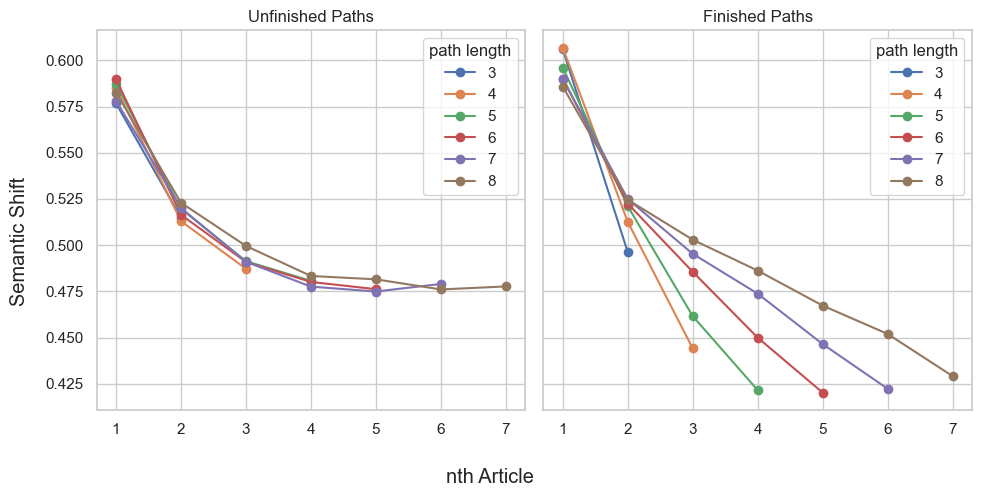

In [49]:
df_uf_shift = pd.read_csv("data/output/cognitive_shift_data/shift_unfinished.csv", index_col=0)
df_pf_shift = pd.read_csv("data/output/cognitive_shift_data/shift_finished.csv", index_col=0)

# display semantic shifts
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.supxlabel("nth Article")
fig.supylabel("Semantic Shift")

df_uf_shift.apply((lambda row: axs[0].plot([int(x) + 1 for x in df_uf_shift.columns.to_list()], row, marker = "o", label=row.name)), axis=1)
axs[0].set_title("Unfinished Paths")
axs[0].legend(title="path length", loc = "upper right")
axs[0].xaxis.set_major_locator(plt.MultipleLocator(1))

df_pf_shift.apply((lambda row: axs[1].plot([int(x) + 1 for x in df_pf_shift.columns.to_list()], row, marker = "o", label=row.name)), axis=1)
axs[1].set_title("Finished Paths")
axs[1].legend(title="path length", loc = "upper right")
axs[1].xaxis.set_major_locator(plt.MultipleLocator(1))

fig.tight_layout()

As can be seen, **semantic shift decreases at the end of finished paths compared to unfinished paths, which tend to stagnate** .
This indicates that, in unfinished paths, the gap in similarity between consecutive articles remains constant, suggesting that the player is "lost"—continuing to change semantic fields without converging on the correct target.
This pattern supports my thesis that higher cognitive shiftings are indeed associated with a greater likelihood of path abandonment.

Semantic shift (finished paths): mean = 0.5030 median = 0.5040
Semantic shift (unfinished paths): mean = 0.5171 median = 0.5179
P-value = 8.395755957977908e-97 so the semantic shift between finished and unfinished paths is statistically different


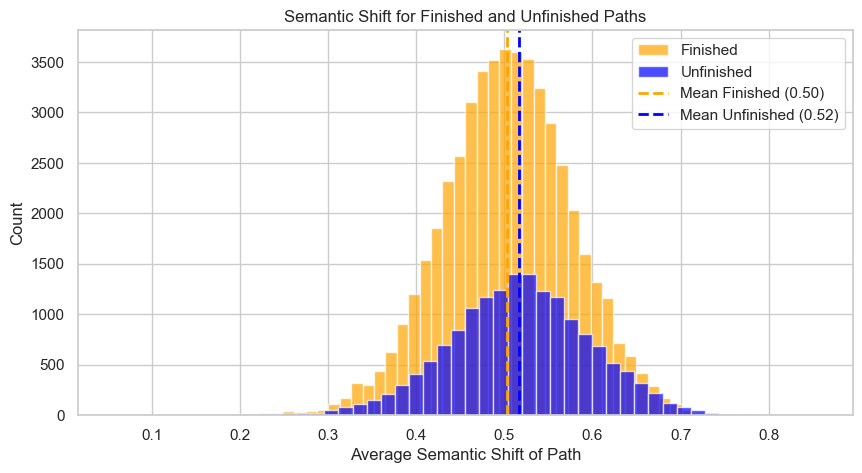

In [50]:
# get all semantic shifts in lists for finished paths and remove nans
mean_semantic_shift_pf = df_semantic_shift[df_semantic_shift["finished"] == True]["average_semantic_shift"]
mean_semantic_shift_pf = [x for x in mean_semantic_shift_pf if ~np.isnan(x)]

# get all semantic shifts in lists for unfinished paths and remove nans
mean_semantic_shift_uf = df_semantic_shift[df_semantic_shift["finished"] == False]["average_semantic_shift"]
mean_semantic_shift_uf = [x for x in mean_semantic_shift_uf if ~np.isnan(x)]

mean_finished = np.mean(mean_semantic_shift_pf)
mean_unfinished = np.mean(mean_semantic_shift_uf)

print(f"Semantic shift (finished paths): mean = {mean_finished:.4f} median = {np.median(mean_semantic_shift_pf):.4f}")
print(f"Semantic shift (unfinished paths): mean = {mean_unfinished:.4f} median = {np.median(mean_semantic_shift_uf):.4f}")
pval = ttest_ind(mean_semantic_shift_pf, mean_semantic_shift_uf).pvalue
print("P-value = {} so the semantic shift between finished and unfinished paths is statistically different".format(pval))

# plot histogram
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_semantic_shift[df_semantic_shift["finished"] == True]["average_semantic_shift"], color='orange', bins=50, alpha=0.7, label="Finished", edgecolor = "white")
ax.hist(df_semantic_shift[df_semantic_shift["finished"] == False]["average_semantic_shift"], color='blue', bins=50, alpha=0.7, label="Unfinished", edgecolor = "white")

# mean lines
ax.axvline(np.mean(mean_semantic_shift_pf), color='orange', linestyle='dashed', linewidth=2, label=f'Mean Finished ({mean_finished:.2f})')
ax.axvline(np.mean(mean_semantic_shift_uf), color='blue', linestyle='dashed', linewidth=2, label=f'Mean Unfinished ({mean_unfinished:.2f})')

ax.set_title("Semantic Shift for Finished and Unfinished Paths")
ax.set_xlabel("Average Semantic Shift of Path")
ax.set_ylabel("Count")

# Display the legend with a cleaner style
ax.legend(frameon=True, loc='upper right')

plt.show()

<span style="color: blue;">**Pepito:**</span>

We can observe that the **semantic shift along finished paths is smaller than for unfinished paths** indicating that finished paths tend to follow more closely related articles than unfinished ones.
This supports the idea that jumping between articles with high differences in similarity can lead to unfinished paths, thus supporting my thesis.

<span style="color: red;">**Dr. Cajal:**</span>

**Although statistically significant, the shift is unfortunately minor**, to the extent that it doesn't represent a practical or relevant change to strongly support your point.
Have you also considered the fact that this slight difference in semantic shift is probably due to the **nature of finished paths**, the last few articles being semantically close as the player is refining his search towards the target.
On the contrary, unfinished paths do not get this final homing in phase, so have slightly higher semantic shift.

# Pepito's last chance: Structural Information

Please refert to the [notebook]().

The next day, Pepito arrives in class eager to present his latest findings to the teacher. Below is a brief summary of their conversation.

## Structural elements catch human Attention

<span style="color: blue;">**Pepito:**</span>

It’s well-established that human attention is drawn to colors and images. I believe that during the game, players are biased toward clicking links near images or other elements besides plain text. As a result, they may end up selecting links that don’t necessarily move them closer to their goal, but instead are simply more visually engaging, leading them off course.

Before proceeding, we present images illustrating the various HTML elements that may appear on a Wikipedia page. These elements play distinct roles in structuring content and can potentially influence player navigation choices:

- **Heading**: Titles and subtitles that organize sections.
- **Paragraph**: Main blocks of text containing information.
- **Table**: Structured data or summaries, often used for comparative or statistical information.
- **List**: Bulleted or numbered items, grouping related points or examples.
- **Infobox**: Highlighted summary boxes, typically on the side, summarizing key information about the topic.
- **Footer**: Content at the bottom, often with references or links to related articles.
- **Undefined**: Elements that don’t fit into the standard categories listed above.

<div align="center">
  <img src="https://p.ipic.vip/ugyvgo.png" alt="structure elements" width="700"/>
  <img src="https://p.ipic.vip/3jipqy.png" alt="footer" width="700"/>
</div>

In [51]:
# Load data
SAVE_FOLDER = "data/output/position_data"
df_position = pd.read_csv(f'{SAVE_FOLDER}/path_links_distribution.csv')
df_position['all_nav_parents'] = df_position['all_nav_parents'].fillna("[]")
df_position['target_parents'] = df_position['target_parents'].fillna("[]")
df_position['num_nav_links'] = df_position['num_nav_links'].apply(ast.literal_eval)
df_position['path_positions'] = df_position['path_positions'].apply(ast.literal_eval)
df_position['all_nav_parents'] = df_position['all_nav_parents'].apply(ast.literal_eval)
df_position['target_parents'] = df_position['target_parents'].apply(ast.literal_eval)

In [52]:
# Category distribution, how many links follow inside a speicific HTML element
df_target_parents_group_categories, df_all_nav_parents_group_categories = get_parents_distribution(df_position)
df_normalized_target_parents_group_categories = df_target_parents_group_categories / df_all_nav_parents_group_categories

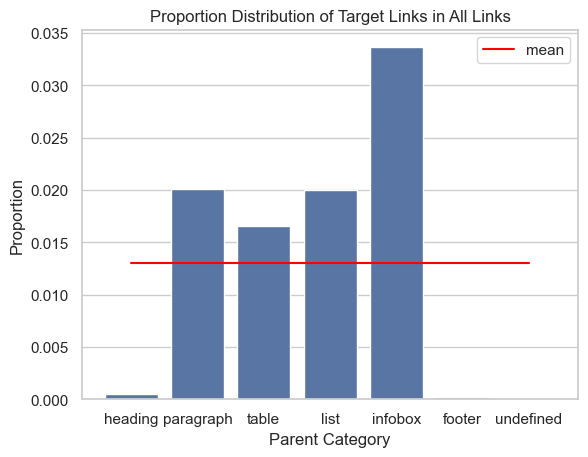

In [53]:
plt.figure()

sns.barplot(x=df_normalized_target_parents_group_categories.index, y=df_normalized_target_parents_group_categories['count'].values)
sns.lineplot(x=df_normalized_target_parents_group_categories.index, y=df_normalized_target_parents_group_categories['count'].mean(), color='red', label='mean')
# ax[1].axhline(y=0, linewidth=2, color='red', )
plt.title('Proportion Distribution of Target Links in All Links')
plt.ylabel('Proportion')
plt.xlabel('Parent Category')

plt.show()

<span style="color: blue;">**Pepito:**</span>

As shown, **after normalizing** the count of links clicked within each HTML category, it becomes clear that players are biased toward the infobox (which almost always includes an image). This strongly supports my argument that visually prominent elements attract more player attention and clicks.


<span style="color: red;">**Dr. Cajal:**</span>

Yes, people are clicking more frequently on infoboxes, even after accounting for the frequency of each element. However, your claim is incorrect. When we compare the frequencies of finished and unfinished paths, we observe that there is no statistically significant difference between the two groups (as confirmed by a *two-sample Kolmogorov-Smirnov test for goodness of fit*). This means that, whether on finished or unfinished paths, players tend to click more on infoboxes. Therefore, even if I am clicking on an infobox, **I have the same likelihood of completing my path**.


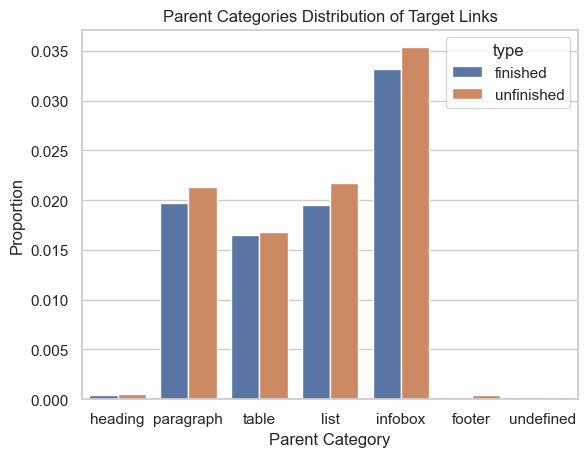

Null Hypothesis: People's choices regarding the structure where target links are located have no impact on whether they can successfully complete the game.
Alternative Hypothesis: People's choice of the structure containing the target link can influence their success in completing the game.
P-value is greater than 0.05. Thus, we fail to reject the null hypothesis. People's choices regarding the structure where target links are located have no impact on whether they can successfully complete the game.


In [54]:
df_position_finished = df_position[df_position['finished']]
df_position_unfinished = df_position[~df_position['finished']]

# Category distribution
df_target_parents_group_categories_finished, df_all_nav_parents_group_categories_finished = get_parents_distribution(df_position_finished)
df_normalized_target_parents_group_categories_finished = df_target_parents_group_categories_finished / df_all_nav_parents_group_categories_finished

# Add type
df_normalized_target_parents_group_categories_finished['type'] = 'finished'

# Category distribution
df_target_parents_group_categories_unfinished, df_all_nav_parents_group_categories_unfinished = get_parents_distribution(df_position_unfinished)
df_normalized_target_parents_group_categories_unfinished = df_target_parents_group_categories_unfinished / df_all_nav_parents_group_categories_unfinished

# Add type
df_normalized_target_parents_group_categories_unfinished['type'] = 'unfinished'

# Merge
df_merged_normalized_target_parents = pd.concat([df_normalized_target_parents_group_categories_finished, df_normalized_target_parents_group_categories_unfinished])


#############################
# Plot
#############################
plt.figure()

sns.barplot(data=df_merged_normalized_target_parents,  x=df_merged_normalized_target_parents.index, y='count', hue='type')
plt.title('Parent Categories Distribution of Target Links')
plt.ylabel('Proportion')
plt.xlabel('Parent Category')

plt.show()

#############################
# Stat test
#############################

# remove "undefined"
indices = ['heading','paragraph','table','list','infobox','footer']


print("Null Hypothesis: People's choices regarding the structure where target links are located have no impact on whether they can successfully complete the game.")
print("Alternative Hypothesis: People's choice of the structure containing the target link can influence their success in completing the game.")
statistic, p_value = ks_2samp(df_normalized_target_parents_group_categories_finished.loc[indices]['count'].values, df_normalized_target_parents_group_categories_unfinished.loc[indices]['count'].values)

if p_value < 0.05:
    print("P-value is less than 0.05. Thus, we reject the null hypothesis. People's choice of the structure containing the target link can influence their success in completing the game.")
else:
    print("P-value is greater than 0.05. Thus, we fail to reject the null hypothesis. People's choices regarding the structure where target links are located have no impact on whether they can successfully complete the game.")

## Link Position & Human Laziness

<span style="color: blue;">**Pepito:**</span>

Humans are inherently lazy and have evolved to minimize the energy spent on tasks. I believe this behavior applies to the Wikipedia game as well. I hypothesize that players are more likely to click on links that appear at the top of the page, as scrolling down and searching for information on a new page requires more time and effort. Based on this assumption, I think players are more likely to abandon optimal links (which may be positioned lower on the page) in favor of easily accessible but less useful links at the top.


Before proceeding, it is important to explain how the position of a link on a page was defined in Pepito's analysis. Since **monitor resolution cannot be inferred from our dataset**, we cannot assume it is the same for every player. Therefore, we are unable to determine the exact position of a link on a webpage a priori.

However, we decided to use the order of link appearance on the page as a metric for position. In cases where a link appears more than once on the same page, the expected value for the position was used.



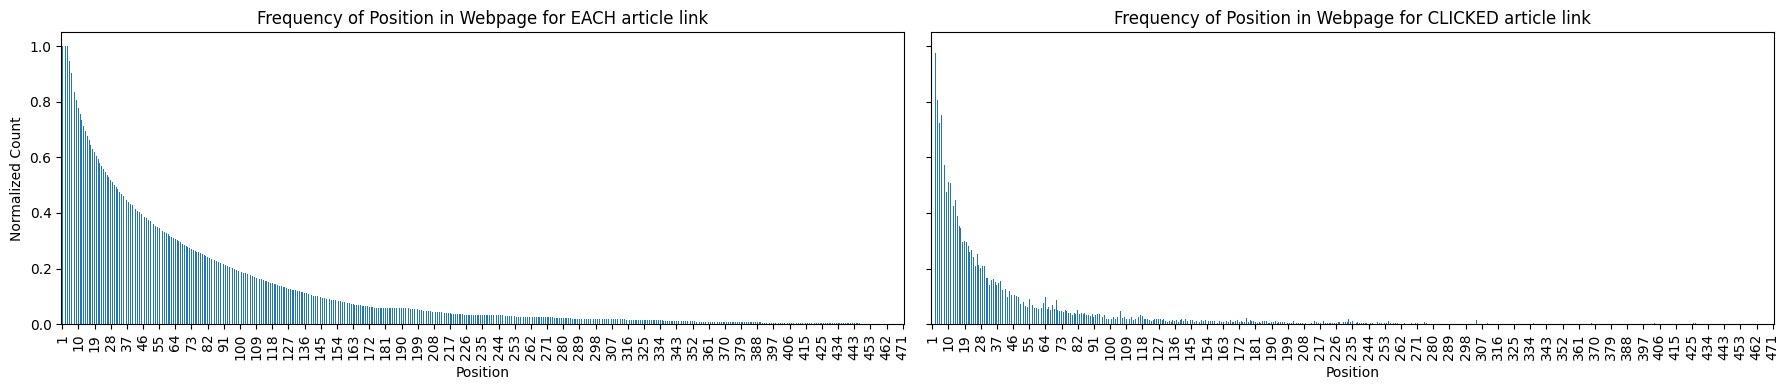

Null Hypothesis: The distributions of cumulative number of navigation links and positions are the same.
Alternative Hypothesis: The distributions of cumulative number of navigation links and positions are not the same.
P-value is less than 0.05. Thus, we reject the null hypothesis. The distributions are significantly different.


In [55]:
# Compute the position distribution
sr_num_nav_links, df_positions_group, df_cum_nav_links = get_position_distribution(df_position)
df_positions_group = df_positions_group[df_positions_group['position'] != -1]

df_cum_nav_links = df_cum_nav_links.sort_values('position')
df_positions_group = df_positions_group.sort_values('position')

sr_cum_nav_links_filtered = df_cum_nav_links[df_cum_nav_links['position'].isin(df_positions_group['position'])]['count']
sr_cum_nav_links_filtered = sr_cum_nav_links_filtered.sort_index()

# Normalize by the maximum value, range from 0 to 1
sr_cum_nav_links_filtered /= max(sr_cum_nav_links_filtered)
df_positions_group['count'] /= df_positions_group['count'].max()

#############################
# Plot
#############################
num_xticks = 50

# Align labels
sr_cum_nav_links_filtered.index+=1

# Reset to default
sns.reset_orig()


fig, ax = plt.subplots(1, 2, sharey=True, figsize=(18, 4))

sr_cum_nav_links_filtered.plot(kind='bar', ax=ax[0])
ax[0].set_title('Frequency of Position in Webpage for EACH article link')
ax[0].set_ylabel('Normalized Count')
ax[0].set_xlabel('Position')
ax[0].set_xticks(ax[0].get_xticks()[::len(ax[0].get_xticks())//num_xticks])

df_positions_group.plot(x='position', y='count', kind='bar', ax=ax[1], legend=False)
ax[1].set_title('Frequency of Position in Webpage for CLICKED article link')
ax[1].set_ylabel('Normalized Count')
ax[1].set_xlabel('Position')
ax[1].set_xticks(ax[1].get_xticks()[::len(ax[1].get_xticks())//num_xticks]) 

plt.tight_layout()
plt.savefig("static/images/position_frequency_clicked_articles.png")
plt.show()

#############################
# Stat test
#############################

print('Null Hypothesis: The distributions of cumulative number of navigation links and positions are the same.')
print('Alternative Hypothesis: The distributions of cumulative number of navigation links and positions are not the same.')
statistic, pvalue = ks_2samp(sr_cum_nav_links_filtered, df_positions_group['count'])

if pvalue < 0.05:
    print('P-value is less than 0.05. Thus, we reject the null hypothesis. The distributions are significantly different.')
else:
    print('P-value is greater than 0.05. Thus, we fail to reject the null hypothesis. The distributions are not significantly different.')

<span style="color: blue;">**Pepito:**</span>

As confirmed by the statistical test, the distribution of clicked links differs from the overall distribution of all links on the webpages. This indicates that people tend to click on links that appear earlier in the article.

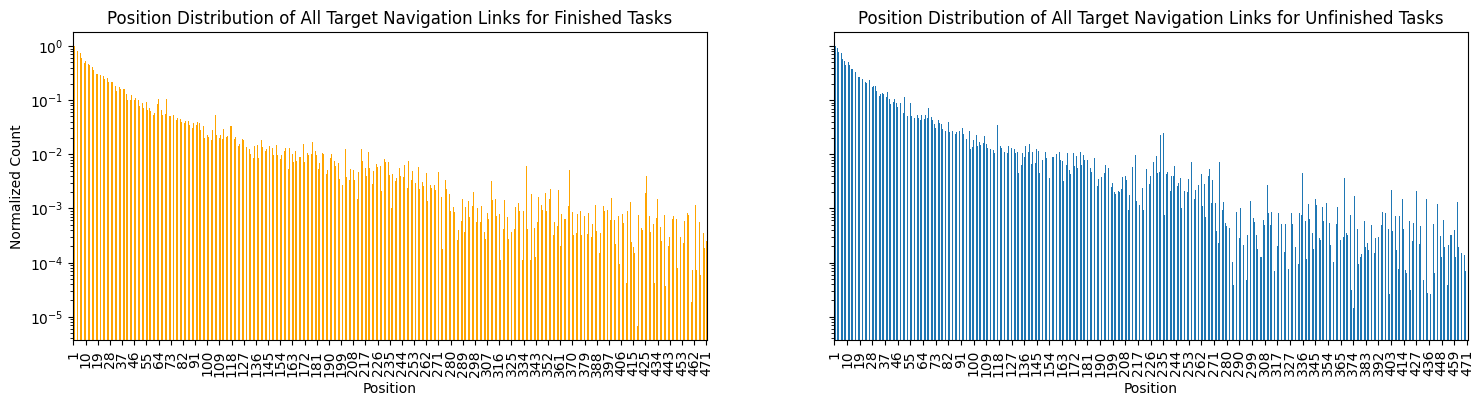

Null Hypothesis: Players who successfully completed the game and those who did not show the same preference in the order of link selection.
Alternative Hypothesis: Players who successfully completed the game and those who did not show different preferences in the order of link selection.
The p-value is:  0.025509189128175347
P-value is less than 0.05. Thus, we reject the null hypothesis. Players who successfully completed the game and those who did not show different preferences in the order of link selection.


In [56]:
# Compute the position distribution - finished
_, df_positions_group_finished, df_cum_nav_links_finished = get_position_distribution(df_position_finished)
df_positions_group_finished = df_positions_group_finished[df_positions_group_finished['position'] != -1]

df_cum_nav_links_finished.sort_values('position', inplace=True)
df_positions_group_finished.sort_values('position', inplace=True)

df_positions_group_finished.sort_index(inplace=True)

# Normalize by the maximum value, range from 0 to 1
df_positions_group_finished['count'] /= df_positions_group_finished['count'].max()

# Compute the position distribution - unfinished
_, df_positions_group_unfinished, df_cum_nav_links_unfinished = get_position_distribution(df_position_unfinished)
df_positions_group_unfinished = df_positions_group_unfinished[df_positions_group_unfinished['position'] != -1]

df_cum_nav_links_unfinished.sort_values('position', inplace=True)
df_positions_group_unfinished.sort_values('position', inplace=True)


df_positions_group_unfinished.sort_index(inplace=True)


# Normalize by the maximum value, range from 0 to 1
df_positions_group_unfinished['count'] /= df_positions_group_unfinished['count'].max()

#############################
# Plot
#############################

num_xticks = 50

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(18, 4))

df_positions_group_finished.plot(x='position', y='count', kind='bar', ax=ax[0], color='orange', legend=False, logy=True)
ax[0].set_title('Position Distribution of All Target Navigation Links for Finished Tasks')
ax[0].set_ylabel('Normalized Count')
ax[0].set_xlabel('Position')
ax[0].set_xticks(ax[0].get_xticks()[::len(ax[0].get_xticks())//num_xticks])

df_positions_group_unfinished.plot(x='position', y='count', kind='bar', ax=ax[1], legend=False, logy=True)
ax[1].set_title('Position Distribution of All Target Navigation Links for Unfinished Tasks')
ax[1].set_ylabel('Normalized Count')
ax[1].set_xlabel('Position')
ax[1].set_xticks(ax[1].get_xticks()[::len(ax[1].get_xticks())//num_xticks]) 

plt.show()

#############################
# Stat test
#############################

print('Null Hypothesis: Players who successfully completed the game and those who did not show the same preference in the order of link selection.')
print('Alternative Hypothesis: Players who successfully completed the game and those who did not show different preferences in the order of link selection.')
statistic, pvalue = ks_2samp(df_positions_group_finished['count'], df_positions_group_unfinished['count'])

print('The p-value is: ', pvalue)
if pvalue < 0.05:
    print('P-value is less than 0.05. Thus, we reject the null hypothesis. Players who successfully completed the game and those who did not show different preferences in the order of link selection.')
else:
    print('P-value is greater than 0.05. Thus, we fail to reject the null hypothesis. Players who successfully completed the game and those who did not show the same preference in the order of link selection.')

<span style="color: blue;">**Pepito:**</span>

This is the final proof! As seen in unfinished paths, the links clicked are closer to the top of the page. This supports my hypothesis that while clicking on initial links may be the most energy-efficient choice for players, it may not be the best strategy for successfully progressing in the game.

<!-- <span style="color: red;">**Dr. Cajal:**</span>

<p align="center">
  <img src="data/assets/pik_speachless.jpeg" alt="Dr. Santiago Ramón y Cajal" width="200"/>
</p> -->


## Sentiment Analisys

<span style="color: blue;">**Pepito:**</span>

Our brain is full of biases, many gained through evolution. One of the most well-known is **choice bias**: if we have to choose, we are most likely to choose the positive option over a negative one (Ref).

Based on this observation, I suspect that during the game, the player—when given the choice of the next article to click on—will be biased toward articles that convey a positive sentiment, even if these articles are not optimal.

To prove this, I will follow these steps:

1. **Calculate Sentiment Values**  
   I will calculate the sentiment value for each article link name. I decided to use only the name and not the full article because, during the choice moment, the user has access only to this limited information.

2. **Categorize Articles**  
   Based on a threshold, I will categorize all articles into **neutral**, **negative**, and **positive** sentiment groups.

3. **Count Sentiments Per Path**  
   For each path, I will count how many **positive**, **negative**, and **neutral** articles it contains.

4. **Balance the Dataset**  
   To ensure balanced classes, I will downsample the dataset to equalize the number of finished and unfinished paths.

<!-- 5. **Path Length**  
   Finally, to account for the possibility that the length of the path could influence the number of positive and negative articles, this variable is also included in the model. -->

Finally, I will fit a logistic regression model using the counts of the three sentiment categories to predict path abandonment. As expected, after following all the steps of a proper machine learning pipeline, I observed that the coefficient for negative sentiment is significant (**p-value < 0.05**). This suggests that choosing negative articles is an important factor in path abandonment.

In [57]:
df_paths_sentiment = pd.read_csv("data/output/sentiment_data/paths_processed_sentiment.csv")

#### Cross-Validation

In [58]:
# Separate features and target variable
X = df_paths_sentiment[['positive_count', 'negative_count', 'neutral_count']]  # You can add other features like 'duration', 'n_click', etc.
y = df_paths_sentiment['finished']

# Logistic Regression model
model = LogisticRegression()

# Perform cross-validation
cv_results = cross_validate(
    model, X, y, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1'], return_train_score=True
)

# Display cross-validation metrics (mean ± std)
print("Cross-Validation Results:")
for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
    mean = np.mean(cv_results[metric])  # Calculate mean
    std = np.std(cv_results[metric])  # Calculate standard deviation
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

Cross-Validation Results:
test_accuracy: 0.5792 ± 0.0058
test_precision: 0.5989 ± 0.0074
test_recall: 0.4795 ± 0.0085
test_f1: 0.5326 ± 0.0072


#### Show Model Coefficients

In [59]:
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit a logistic regression model using statsmodels
model = sm.Logit(y, X)
result = model.fit(maxiter=1000)

# Get a summary of the regression results
print(result.summary())

# Display the coefficients, standard errors, and p-values for each feature
coefficients = result.params
std_errors = result.bse
z_scores = result.tvalues
p_values = result.pvalues

# Print detailed results for coefficients, std errors, z-scores, and p-values
print("\nDetailed Coefficients Information:")
for feature, coef, std_err, z_score, p_value in zip(X.columns, coefficients, std_errors, z_scores, p_values):
    print(f"{feature}: Coefficient = {coef:.4f}, Std Error = {std_err:.4f}, Z-score = {z_score:.4f}, P-value = {p_value:.4f}")

# Optionally, calculate confidence intervals for the coefficients
conf_int = result.conf_int()
print("\nConfidence Intervals for Coefficients:")
print(conf_int)


Optimization terminated successfully.
         Current function value: 0.684525
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               finished   No. Observations:                45668
Model:                          Logit   Df Residuals:                    45664
Method:                           MLE   Df Model:                            3
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                 0.01244
Time:                        15:36:24   Log-Likelihood:                -31261.
converged:                       True   LL-Null:                       -31655.
Covariance Type:            nonrobust   LLR p-value:                2.222e-170
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3594      0.017    -21.685      0.000      -0.392      -0.327
positive_count   

<span style="color: red;">**Dr. Cajal:**</span>

Pepito, Pepito, don’t you see you’re climbing mirrors here? Indeed, your data preprocessing pipeline for the logistic regression model is well-structured, but basing your analysis solely on the coefficients makes no sense.

Firstly, the coefficient contradicts your hypothesis. It is **positive (+0.05)**, which means that as the number of negative articles increases, the probability of finishing the path also increases. This is the opposite of your assumption. Secondly, the model’s accuracy is **50%**, and with only two classes, this implies that the model is effectively guessing randomly. There is no meaningful information being captured in the negative or positive paths.

This observation aligns with previous findings where users searched for hub articles regardless of their sentiment. For instance, "WW2" is frequently part of finished paths despite being counted as conveying negative sentiment.

Lastly, even if your model had achieved better accuracy, I am skeptical about its reliability. In analyses like these, many variables can confound the results. For instance:
- There might not be an equal number of positive and negative articles on the current webpage to choose from.
- Negative articles might tend to appear at the bottom of the page or not accompanied by images.

Without addressing these potential biases, it’s impossible to make a fair comparison between positive and negative articles.

Pepito stop! You do not only know how to play wikispeedia, but you are also the worst dataanayst I have ever seen.
I recommend you also to play ADA course ;).

***

# Conclusion

After testing many different approaches to validate cognitive overload and various cognitive biases, **Pepito was unable to defend his point.** 
Namely:

- Path Length and Duration  
- Readability Metrics  
- Shannon Entropy  
- Graph Connectivity  
- Cognitive Shifts  
- Webpage Structural Elements  
- Sentiment Analysis  

were unable to prove his point.  
It seems the poor results he achieved were **simply due to a lack of knowledge**, nothing more.  

Pepito’s arguments were thoroughly dismantled by Dr. Cajal, who employed **impeccable data analysis techniques.**  
Rather than dismissing Pepito outright, Dr. Cajal patiently listened to his perspective and took the time to **teach him the principles** of conducting a robust and meticulous analysis.
